### Import Library

In [5]:
import os
import time
import numpy as np
import polars as pl
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import numpy as np


### Configs

In [6]:
input_size = 30
label_size = 1
offset = 1
train_size = 0.7
val_size = 0.1
num_epochs = 1_000_000
patience = 20
learning_rate = 0.00001
hidden_size = 64
num_layers = 4
ele = 5

target_name = 'precipprob'
date_column = 'datetime'
file_path = '../../assets/weather_14y.csv'

plot_dir = 'plots'
weight_dir = 'weights'
results =  []

### Concat 3 location 

In [1]:
# import pandas as pd

# # Read the CSV files
# hanoi = pd.read_csv('../../assets/hanoi.csv')
# danang = pd.read_csv('../../assets/danang.csv')
# hochiminh = pd.read_csv('../../assets/hochiminh.csv')


In [3]:
# hanoi.shape, danang.shape, hochiminh.shape

((5265, 33), (5265, 33), (5265, 33))

In [4]:

# # Concatenate the dataframes
# df = pd.concat([hanoi, danang, hochiminh])

# # If you want to save the concatenated dataframe to a new CSV file, you can do this:
# df.to_csv('../../assets/combined.csv', index=False)

### Data preparation

In [7]:
class TimeSeriesDataLoader:
    def __init__(self, file_path, input_size, label_size, offset, train_size, val_size, date_column=None, target_name=None, features_type='M', batch_size=64):
        if offset < label_size:
            print(f'Offset will be change from {offset} to {label_size}')
            offset = label_size
        self.input_size = input_size
        self.label_size = label_size
        self.offset = offset
        self.train_size = train_size
        self.val_size = val_size
        self.target_name = target_name
        self.features_type = features_type
        self.batch_size = batch_size

        self.df = pl.read_csv(file_path)
        if date_column is not None: 
            self.df = self.df.drop('datetime')
            self.df = self.df.drop('preciptype')
            self.df = self.df.drop('sealevelpressure')
            self.df = self.df.drop('winddir')
            self.df = self.df.drop('solarradiation')
            self.df = self.df.drop('conditions')

        if features_type == 'S':
            self.in_variable = 1
            self.out_variable = 1
        elif features_type == 'M':
            self.in_variable = len(self.df.columns)
            self.out_variable = len(self.df.columns)
        elif features_type == 'MS':
            self.in_variable = len(self.df.columns)
            self.out_variable = 1
        else:
            raise ValueError('Features type must be S, M or MS')
        
        self.X_train, self.y_train = self.__create_dataset(0, int(train_size*len(self.df)))
        print(f'{self.X_train.shape=}')
        print(f'{self.y_train.shape=}')
        self.X_val, self.y_val = self.__create_dataset(int(train_size*len(self.df)), int((train_size+val_size)*len(self.df)))
        print(f'{self.X_val.shape=}')
        print(f'{self.y_val.shape=}')
        self.X_test, self.y_test = self.__create_dataset(int((train_size+val_size)*len(self.df)), None)



        # self.X_train = self.normalize_data(self.X_train)  # Normalize training data
        # self.X_val = self.normalize_data(self.X_val)  # Normalize validation data
        # self.X_test = self.normalize_data(self.X_test)  # Normalize test data
        # self.y_train = self.normalize_data(self.y_train)  # Normalize training data
        # self.y_val = self.normalize_data(self.y_val)  # Normalize validation data
        # self.y_test = self.normalize_data(self.y_test)  # Normalize test data
        self.train_loader = self.__create_dataloader(self.X_train, self.y_train)
        self.val_loader = self.__create_dataloader(self.X_val, self.y_val)
        self.test_loader = self.__create_dataloader(self.X_test, self.y_test)



    def normalize_data(self, data):
        min_vals = np.min(data, axis=0)
        max_vals = np.max(data, axis=0)
        normalized_data = (data - min_vals) / (max_vals - min_vals)
        return normalized_data

    def __create_dataset(self, start_idx, end_idx):
        if end_idx is None:
            end_idx = len(self.df) - self.label_size - self.offset
        start_idx += self.input_size + self.offset
        features = []
        labels = []

        for idx in range(start_idx, end_idx):
            feature_start_idx = idx - self.input_size - self.offset 
            feature_end_idx = feature_start_idx + self.input_size

            label_start_idx = idx - 1
            label_end_idx = label_start_idx + self.label_size

            if self.features_type == 'S':
                feature = self.df.select(self.target_name)[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            elif self.features_type == 'M':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df[label_start_idx:label_end_idx]
            elif self.features_type == 'MS':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            else:
                raise ValueError('Features type must be S, M or MS')
            features.append(feature.to_numpy())
            labels.append(label.to_numpy())
            self.out_features = label.columns
            self.in_features = label.columns
        return np.array(features), np.array(labels)
    def __create_dataloader(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)


In [8]:
features_type = 'MS'
sub_dir = 'multi2uni'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2uni_loader = TimeSeriesDataLoader(file_path, input_size = input_size, label_size= label_size, offset=offset,train_size=train_size, val_size=val_size, target_name=target_name, features_type=features_type, date_column=date_column)

self.X_train.shape=(3654, 30, 17)
self.y_train.shape=(3654, 1, 1)
self.X_val.shape=(496, 30, 17)
self.y_val.shape=(496, 1, 1)


In [9]:
features_type = 'M'
sub_dir = 'multi2multi'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2multi_loader = TimeSeriesDataLoader(file_path, input_size = input_size, label_size= label_size, offset=offset,train_size=train_size, val_size=val_size, target_name=target_name, features_type=features_type, date_column=date_column)

self.X_train.shape=(3654, 30, 17)
self.y_train.shape=(3654, 1, 17)
self.X_val.shape=(496, 30, 17)
self.y_val.shape=(496, 1, 17)


In [10]:
multi2multi_loader.df

shape: (5_265, 17)
┌─────────┬─────────┬──────┬──────────────┬───┬────────────┬─────────────┬─────────┬───────────┐
│ tempmax ┆ tempmin ┆ temp ┆ feelslikemax ┆ … ┆ visibility ┆ solarenergy ┆ uvindex ┆ moonphase │
│ ---     ┆ ---     ┆ ---  ┆ ---          ┆   ┆ ---        ┆ ---         ┆ ---     ┆ ---       │
│ f64     ┆ f64     ┆ f64  ┆ f64          ┆   ┆ f64        ┆ f64         ┆ i64     ┆ f64       │
╞═════════╪═════════╪══════╪══════════════╪═══╪════════════╪═════════════╪═════════╪═══════════╡
│ 33.1    ┆ 22.1    ┆ 26.6 ┆ 34.1         ┆ … ┆ 9.6        ┆ 18.9        ┆ 8       ┆ 0.5       │
│ 32.0    ┆ 22.0    ┆ 27.1 ┆ 34.9         ┆ … ┆ 9.9        ┆ 20.1        ┆ 8       ┆ 0.55      │
│ 32.2    ┆ 24.0    ┆ 27.2 ┆ 36.8         ┆ … ┆ 9.9        ┆ 20.0        ┆ 8       ┆ 0.58      │
│ 32.0    ┆ 23.0    ┆ 27.2 ┆ 33.5         ┆ … ┆ 10.3       ┆ 20.9        ┆ 8       ┆ 0.62      │
│ 33.0    ┆ 23.1    ┆ 27.1 ┆ 36.1         ┆ … ┆ 10.3       ┆ 20.9        ┆ 8       ┆ 0.65      │
│ …       ┆ …       ┆ …    ┆ …            ┆ … ┆ …          ┆ …           ┆ …       ┆ …         │
│ 37.0    ┆ 28.7    ┆ 31.7 ┆ 46.8         ┆ … ┆ 10.1       ┆ 17.6        ┆ 9       ┆ 0.63      │
│ 32.0    ┆ 28.9    ┆ 29.9 ┆ 44.1         ┆ … ┆ 9.1        ┆ 18.8        ┆ 8       ┆ 0.67      │
│ 34.0    ┆ 28.0    ┆ 30.7 ┆ 44.0         ┆ … ┆ 9.0        ┆ 16.6        ┆ 8       ┆ 0.7       │
│ 34.0    ┆ 27.0    ┆ 29.5 ┆ 44.0         ┆ … ┆ 8.9        ┆ 6.4         ┆ 4       ┆ 0.74      │
│ 34.0    ┆ 26.7    ┆ 29.5 ┆ 42.2         ┆ … ┆ 14.7       ┆ 14.2        ┆ 9       ┆ 0.75      │
└─────────┴─────────┴──────┴──────────────┴───┴────────────┴─────────────┴─────────┴───────────┘

/tmp/ipykernel_20243/3940507953.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)  # Rotate x-axis labels by 90 degrees
/tmp/ipykernel_20243/3940507953.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)  # Rotate x-axis labels by 90 degrees
/tmp/ipykernel_20243/3940507953.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)  # Rotate x-axis labels by 90 degrees
/tmp/ipykernel_20243/3940507953.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xtickl

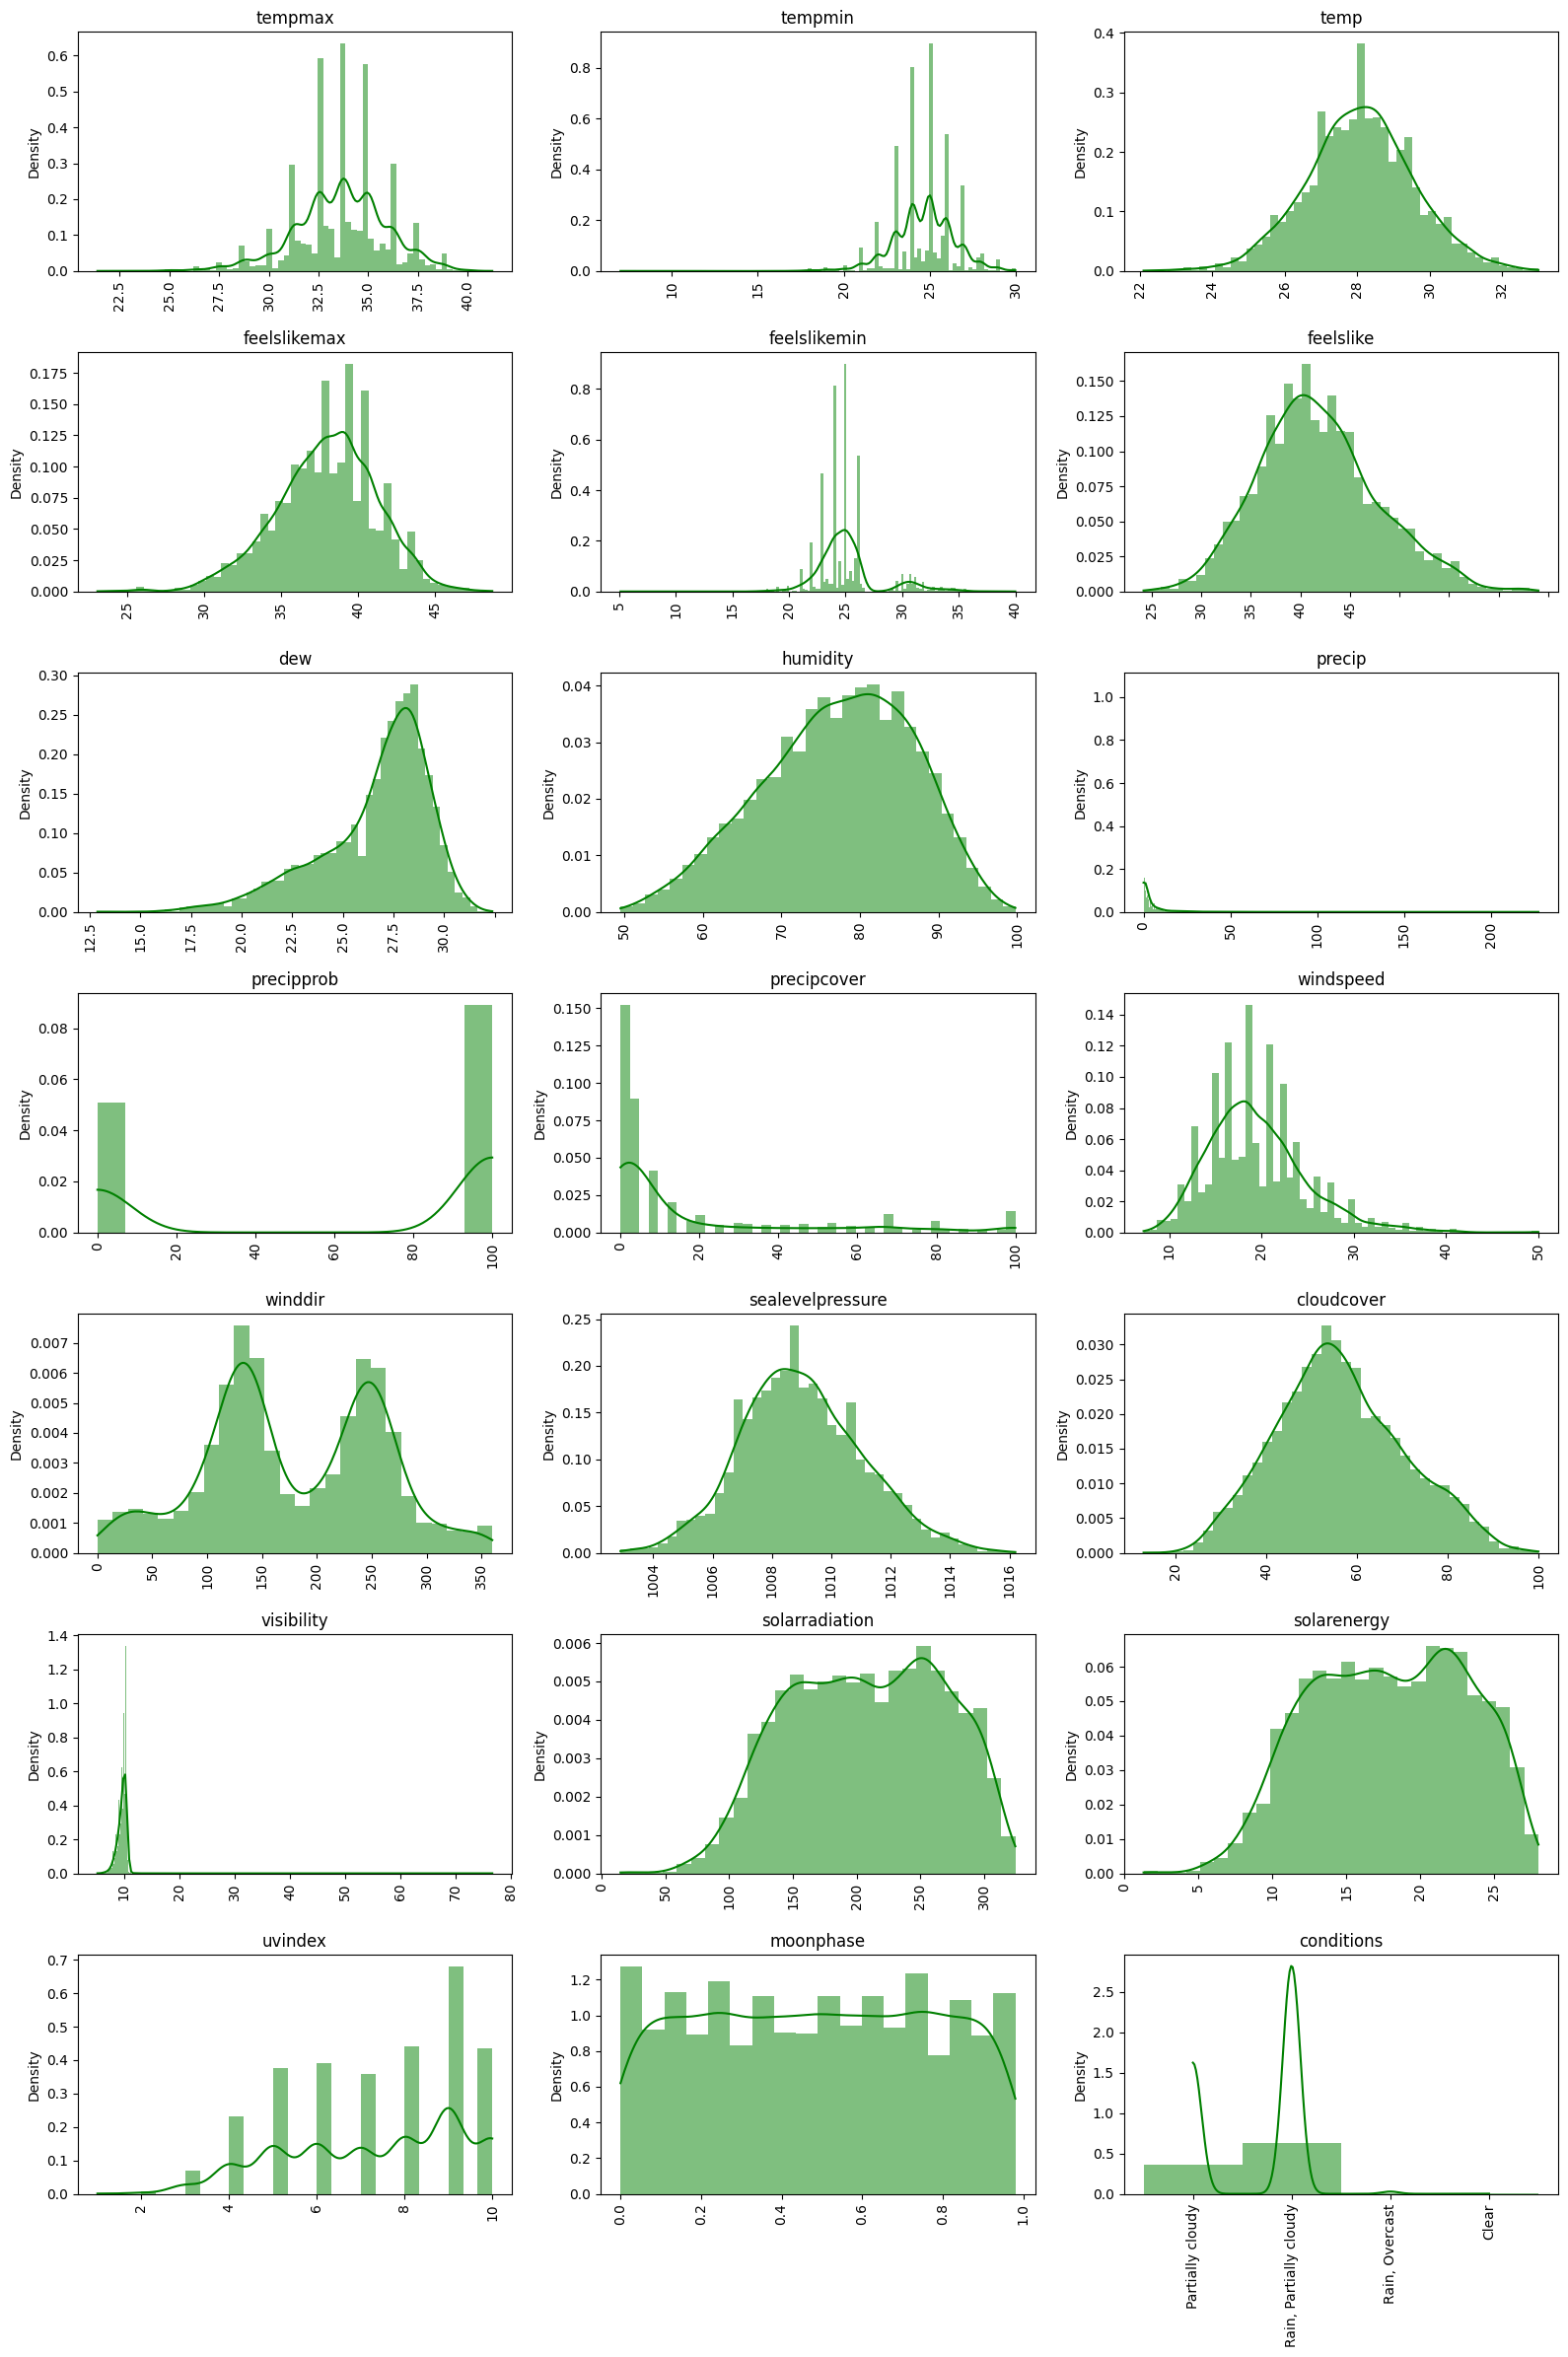

In [35]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_df = pl.read_csv(file_path)
train_df = train_df.drop('datetime')

columns_to_plot = train_df.columns
num_columns = 3
num_rows = int(np.ceil(len(columns_to_plot) / num_columns))
grid_layout = (num_rows, num_columns)
fig, axes = plt.subplots(*grid_layout, figsize=(16, 24))
axes = axes.flatten()
for i, column in enumerate(columns_to_plot):
    sns.histplot(train_df[column], kde=True, ax=axes[i], color='green', stat="density", linewidth=0)
    axes[i].set_title(column)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)  # Rotate x-axis labels by 90 degrees
plt.tight_layout()
plt.savefig('visualization.png')
plt.show()

### Training Model Preparation

In [72]:
import torch
import torch.nn as nn
import os
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class ModelManager:
    def __init__(self, model, train_loader, val_loader=None, lr=0.0001, patience=100):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.train_loss_per_epoch = []
        self.val_loss_per_epoch = []

    def train(self, num_epochs, save_dir='.'):
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()
            total_train_loss = 0
            for inputs, targets in self.train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_train_loss += loss.item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            avg_train_loss = total_train_loss / len(self.train_loader)
            self.train_loss_per_epoch.append(avg_train_loss)

            val_loss = self.evaluate(loader=self.val_loader) 
            self.val_loss_per_epoch.append(val_loss)  
            if self.early_stopping(val_loss, save_path):
                print(f'Early stopping on epoch {epoch + 1}')
                return
            print(f'Epoch {epoch + 1}/{num_epochs}, train_loss: {avg_train_loss:.4f}, val_loss: {val_loss:.4f}, time: {time.time() - start_time:.2f}s')
        self.save_model(save_path)
    
    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        return avg_loss
    
    def calculate_accuracy(self, data_loader):
        self.model.eval()
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.predict(inputs)
                _, predicted = torch.max(outputs, 1)
                total_predictions += targets.size(0)
                correct_predictions += (predicted == targets).sum().item()
        return correct_predictions / total_predictions

    def early_stopping(self, val_loss, save_path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience
    
    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f'Model saved to {save_path}')
    
    def load_model(self, load_path):
        self.model.load_state_dict(torch.load(load_path))
        print(f'Model loaded from {load_path}')
    
    def predict(self, input_data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(device)
        self.model.eval()
        if isinstance(input_data, DataLoader):
            predictions = []
            with torch.no_grad():
                for inputs, _ in input_data:
                    inputs = inputs.to(device)
                    outputs = self.model(inputs)
                    predictions.append(outputs)
            predictions = torch.cat(predictions, dim=0)
        else:
            with torch.no_grad():
                input_data = input_data.to(device)
                predictions = self.model(input_data).unsqueeze(0)
        return predictions

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None: 
            feature_names = [f'Feature {i+1}' for i in range(y.shape[2])]
            
        if num_elements is not None:
            y = y[:num_elements]
            yhat = yhat[:num_elements]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10,5))
            plt.plot(y[:,:,feature_index].flatten(), label='y', linestyle='-')
            plt.plot(yhat[:,:,feature_index].flatten().cpu().numpy(), label='y_hat', linestyle='--')
            plt.title(f'{feature_name} Forecast')
            plt.xlabel('Time Steps')
            plt.ylabel('Values')
            plt.legend()
            if save_plots:
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name}.png')
                plt.savefig(save_path)
            plt.show()
            plt.close()
    def plotMC(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None: 
            feature_names = [f'Feature {i+1}' for i in range(y.shape[2])]
            
        if num_elements is not None:
            y = y[:num_elements]
            yhat = yhat[:num_elements]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10,5))
            plt.plot(y[:,:,feature_index].flatten(), label='y', linestyle='-')
            plt.plot(yhat[:,:,feature_index].flatten(), label='y_hat', linestyle='--')
            plt.title(f'{feature_name} Forecast')
            plt.xlabel('Time Steps')
            plt.ylabel('Values')
            plt.legend()
            if save_plots:
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name}.png')
                plt.savefig(save_path)
            plt.show()
            plt.close()
            

class MachineLearningModelManager(ModelManager):
    def __init__(self, model, xtrain, ytrain, xval, yval):
        self.model = model
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xval = xval
        self.yval = yval
    def preprocessing(self, x):
        return x.reshape(x.shape[0], -1)
    
    def save_model(self, save_path):
        import pickle
        with open(save_path, 'wb') as model_file:
            pickle.dump(self.model, model_file)
        print(f'Model saved to {save_path}')
    def train(self, save_dir='.'):
        self.model.fit(self.preprocessing(self.xtrain), self.preprocessing(self.ytrain),eval_set=[(self.preprocessing(self.xval), self.preprocessing(self.yval))])
        save_path = os.path.join(save_dir, f'best={self.model.__class__.__name__}.pkl')
        self.save_model(save_path=save_path)
    def predict(self, x):
        return self.model.predict(self.preprocessing(x))

    def evaluate(self, x, y):
        from sklearn.metrics import mean_absolute_error
        # print(self.preprocessing(y).shape)
        # print(self.predict(self.preprocessing(x)).shape)
        return mean_absolute_error(self.preprocessing(y), self.predict(self.preprocessing(x)))
    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        yhat = yhat.reshape(y.shape[0], y.shape[1], -1)
        super().plotMC(y, yhat, feature_names=feature_names, save_dir=save_dir, save_plots=save_plots, num_elements=num_elements)

### Build Models

In [73]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, ahead):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size * ahead)
        self.ahead = ahead
        self.output_size=output_size
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.view(-1, self.ahead, self.output_size)

In [74]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * ahead)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x.to(self.device), (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [75]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * ahead)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [76]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(BiLSTM, self).__init__()  
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size * ahead)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

### Exercuse Models

#### MLP model

In [77]:
# MLP_multi2multi = MLP(input_size=multi2multi_loader.in_variable*input_size, hidden_size=hidden_size, output_size=multi2multi_loader.out_variable, ahead=label_size)

# MLP_multi2multi_manager = ModelManager(model=MLP_multi2multi, train_loader=multi2multi_loader.train_loader,val_loader=multi2multi_loader.val_loader, lr=learning_rate, patience=patience)
# MLP_multi2multi_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
# results.append({
#     "Name": MLP_multi2multi_manager.model.__class__.__name__,
#     "Type": sub_dir,
#     'MAE': MLP_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader),
# })
# results[-1]

In [78]:
# mul2mul_data_x = multi2multi_loader.train_loader
# mul2mul_data_y = multi2multi_loader.y_train
# model_activation = MLP_multi2multi_manager
# yhat = model_activation.predict(mul2mul_data_x)

# # Get the true values
# y = mul2mul_data_y

# # Plot the true values against the predictions
# model_activation.plot(y,yhat, feature_names=["tempmax","tempmin","temp","feelslikemax","feelslikemin","feelslike","dew","humidity","precip","precipprob","precipcover","windspeed","cloudcover","visibility","solarenergy","uvindex","moonphase"], num_elements=200, save_plots=False)

#### XgBoost Model

In [79]:
xgboost_config = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'booster': 'gbtree',
    'n_estimators': num_epochs,
    'max_depth': 3,
    'learning_rate': 0.01,
    'early_stopping_rounds': patience,
}

In [80]:
XGBoost_multi2multi = XGBRegressor(**xgboost_config)
XGBoost_multi2multi_manager = MachineLearningModelManager(model = XGBoost_multi2multi, xtrain = multi2multi_loader.X_train, ytrain = multi2multi_loader.y_train, xval = multi2multi_loader.X_val, yval = multi2multi_loader.y_val)
XGBoost_multi2multi_manager.train(save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": XGBoost_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_multi2multi_manager.evaluate(x=multi2multi_loader.X_test, y=multi2multi_loader.y_test)
})
results[-1]

[0]	validation_0-mae:17.50337
[1]	validation_0-mae:17.35276
[2]	validation_0-mae:17.20398
[3]	validation_0-mae:17.05674
[4]	validation_0-mae:16.91106
[5]	validation_0-mae:16.76667
[6]	validation_0-mae:16.62399
[7]	validation_0-mae:16.48255
[8]	validation_0-mae:16.34280
[9]	validation_0-mae:16.20431
[10]	validation_0-mae:16.06736
[11]	validation_0-mae:15.93161
[12]	validation_0-mae:15.79756
[13]	validation_0-mae:15.66504
[14]	validation_0-mae:15.53320
[15]	validation_0-mae:15.40343
[16]	validation_0-mae:15.27440
[17]	validation_0-mae:15.14720
[18]	validation_0-mae:15.02127
[19]	validation_0-mae:14.89628
[20]	validation_0-mae:14.77325
[21]	validation_0-mae:14.65094
[22]	validation_0-mae:14.52984
[23]	validation_0-mae:14.40970
[24]	validation_0-mae:14.29133
[25]	validation_0-mae:14.17405
[26]	validation_0-mae:14.05809
[27]	validation_0-mae:13.94304
[28]	validation_0-mae:13.82917
[29]	validation_0-mae:13.71702
[30]	validation_0-mae:13.60537
[31]	validation_0-mae:13.49480
[32]	validation_0-

{'Name': 'XGBRegressor', 'Type': 'multi2multi', 'MAE': 3.8474055223917256}

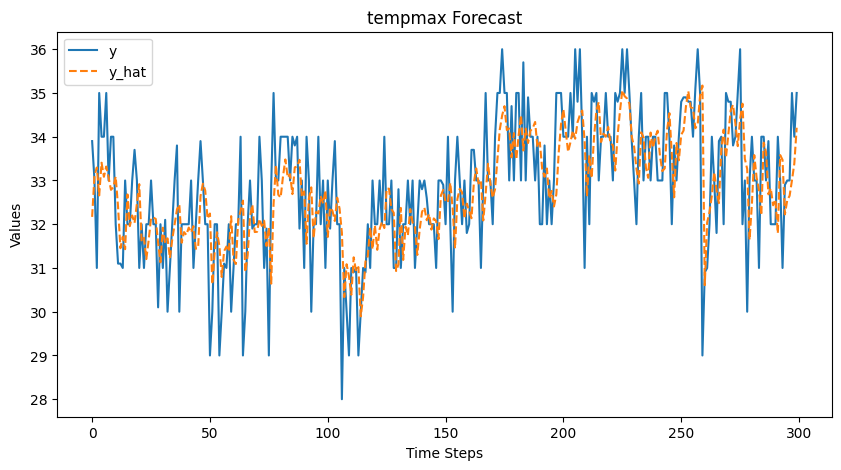

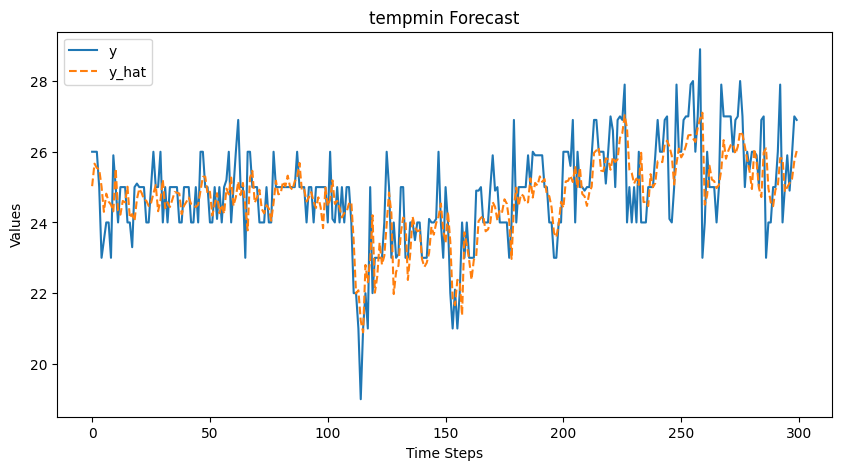

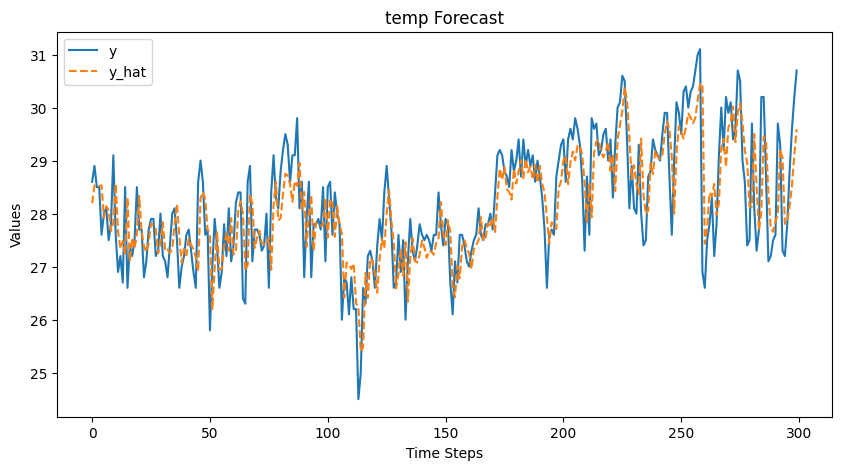

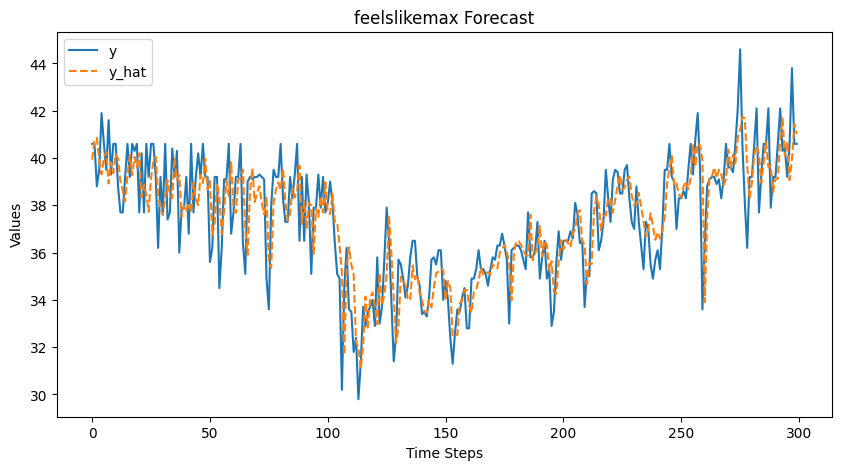

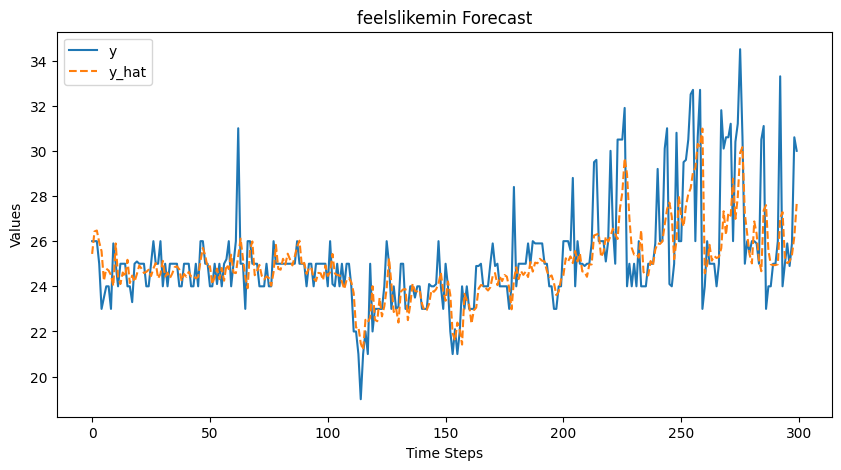

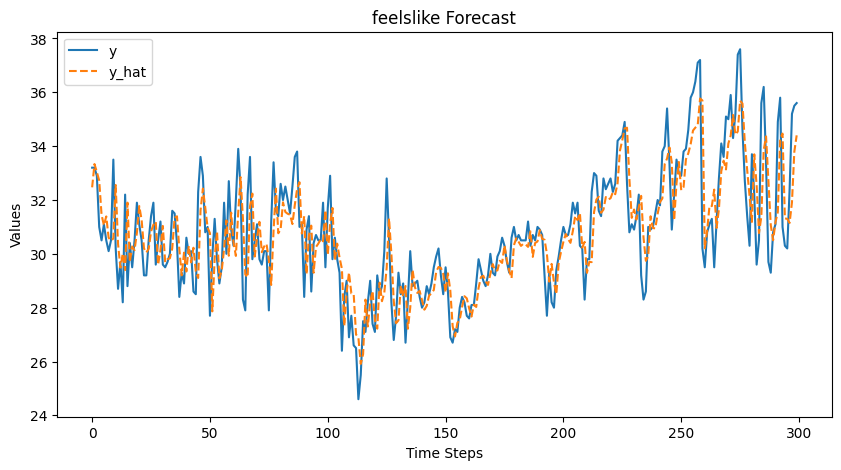

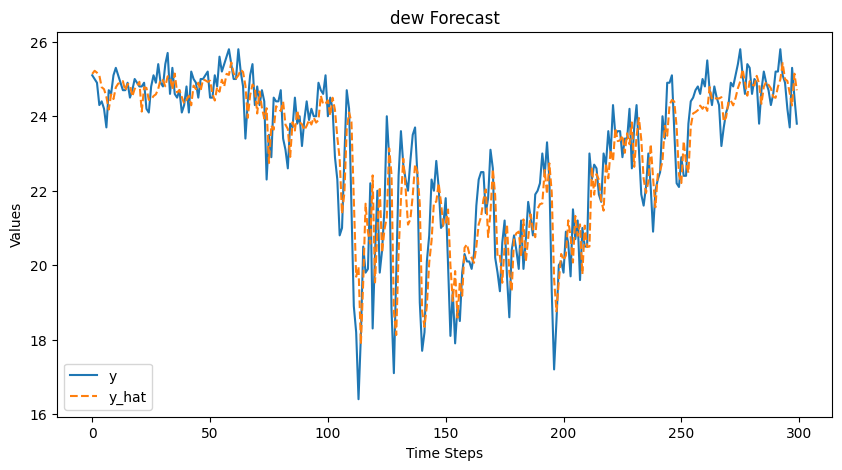

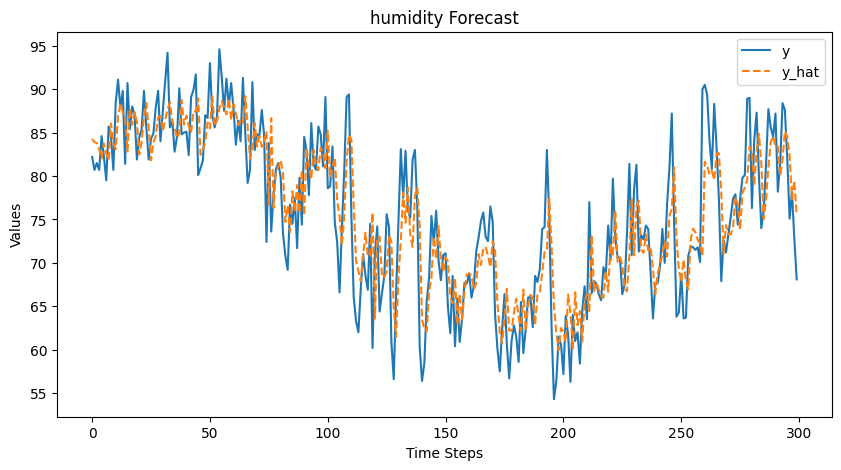

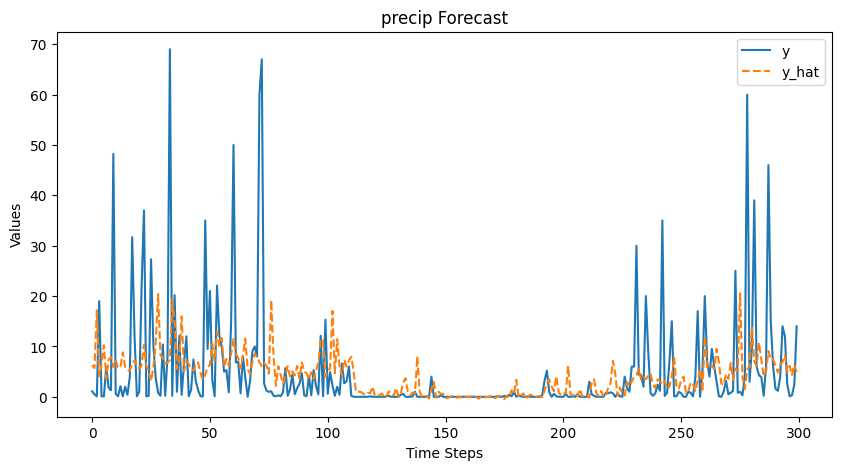

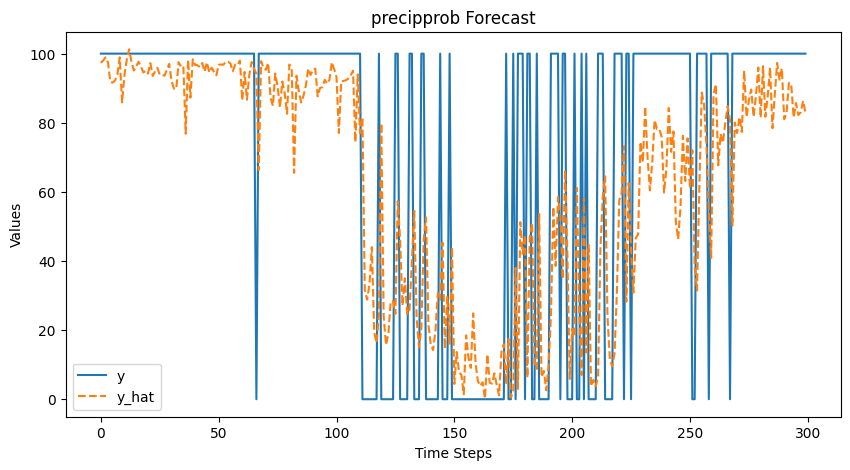

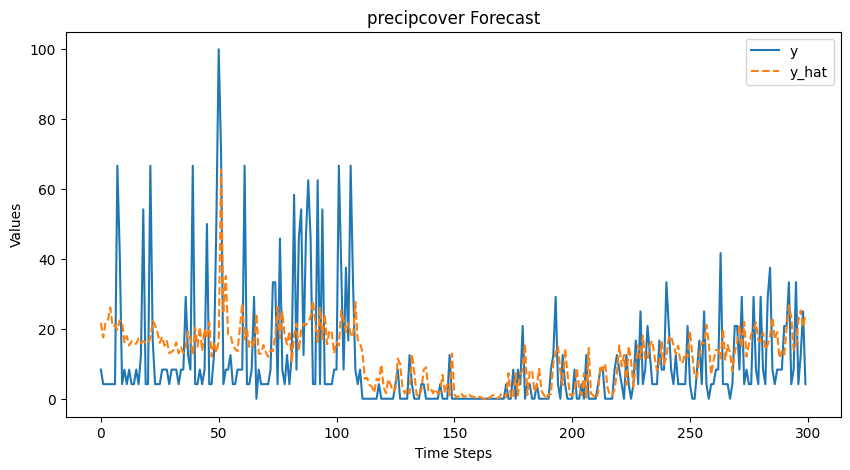

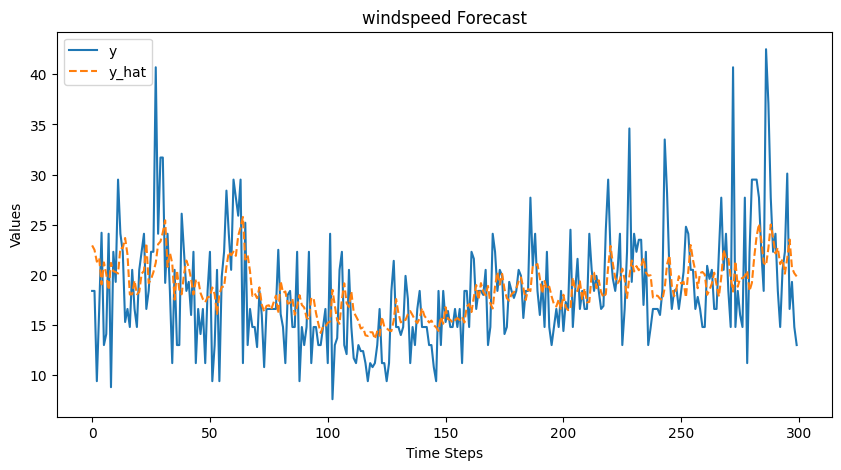

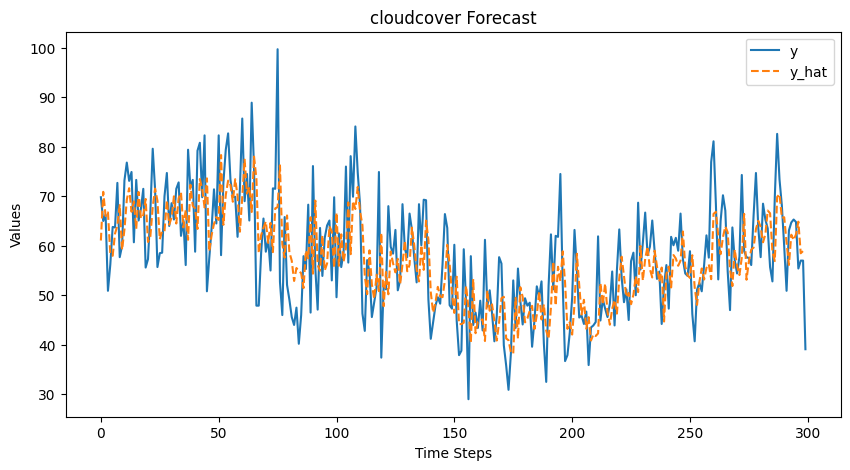

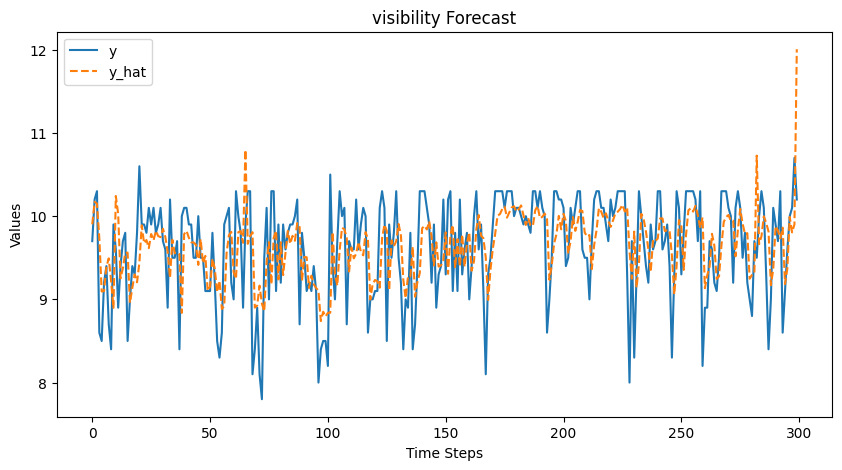

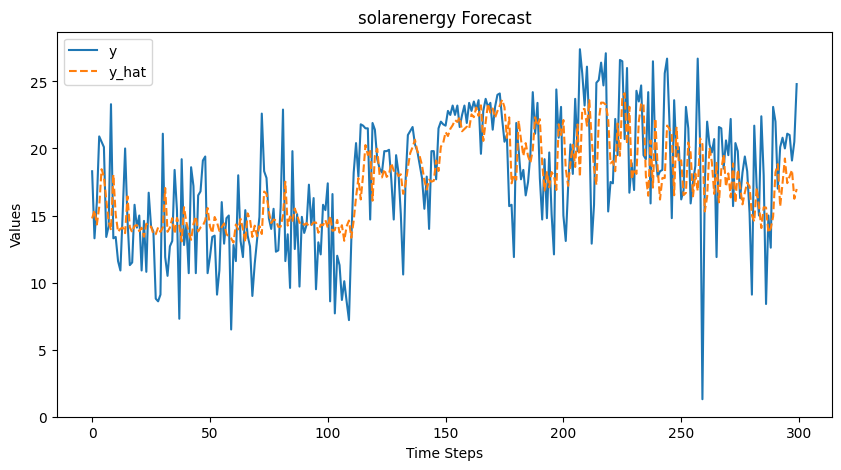

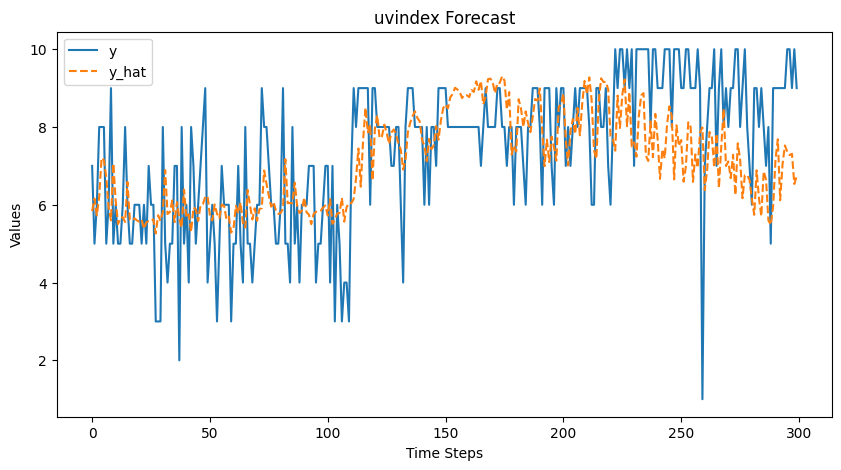

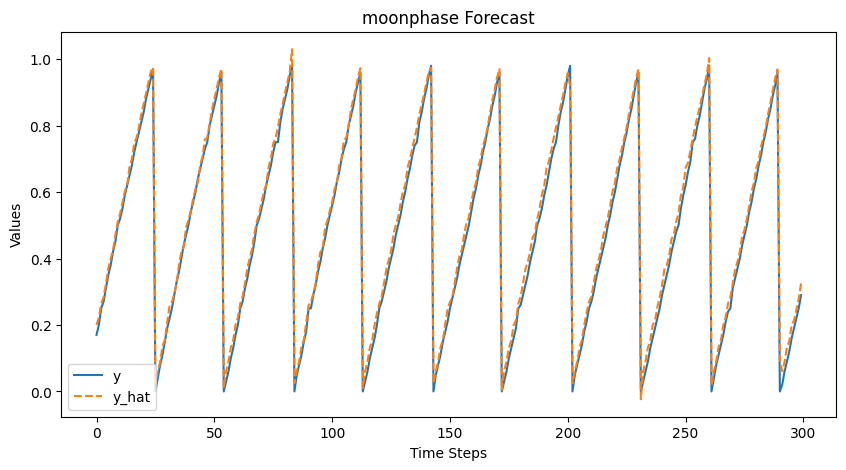

In [82]:
# Generate predictions on the training data
mul2mul_data_x = multi2multi_loader.X_test
mul2mul_data_y = multi2multi_loader.y_test
model_activation = XGBoost_multi2multi_manager
yhat = model_activation.predict(mul2mul_data_x)

# Get the true values
y = mul2mul_data_y

# Plot the true values against the predictions
model_activation.plot(y,yhat, feature_names=["tempmax","tempmin","temp","feelslikemax","feelslikemin","feelslike","dew","humidity","precip","precipprob","precipcover","windspeed","cloudcover","visibility","solarenergy","uvindex","moonphase"], num_elements=300, save_plots=True)

In [54]:
mul2mul_data_x = multi2multi_loader.X_test
mul2mul_data_x.shape

(1020, 30, 17)

In [55]:
last_30_days_data = multi2multi_loader.X_test[-30:]
last_30_days_data.shape

(30, 30, 17)

In [56]:
# Get the last sequence of 30 days
last_30_days_data = multi2multi_loader.X_test[-1:]
# Predict the next 7 days
next_7_days_prediction = []
for _ in range(7):
    next_day_prediction = XGBoost_multi2multi_manager.predict(last_30_days_data)
    next_7_days_prediction.append(next_day_prediction)

    # Append the predicted value to the end of your sequence and remove the first value
    next_day_prediction = next_day_prediction.reshape(1, 1, 17)  # Reshape to match the input shape
    last_30_days_data = np.concatenate((last_30_days_data[:, 1:, :], next_day_prediction), axis=1)

print("The predicted values for the next 7 days are:", next_7_days_prediction)

The predicted values for the next 7 days are: [array([[0.74502665, 0.7991949 , 0.79567087, 0.74499935, 0.7511506 ,
        0.821002  , 0.8962466 , 0.5700963 , 0.04681096, 0.8111896 ,
        0.20417716, 0.38477376, 0.45633405, 0.10058247, 0.4894303 ,
        0.5375622 , 0.68366766]], dtype=float32), array([[0.78178316, 0.7287681 , 0.71047765, 0.7491452 , 0.7075252 ,
        0.7568425 , 0.88133824, 0.6031429 , 0.03730313, 0.8367414 ,
        0.24437633, 0.3622881 , 0.47568005, 0.10053091, 0.413339  ,
        0.47047803, 0.73018044]], dtype=float32), array([[0.74790686, 0.7813479 , 0.71203786, 0.7327269 , 0.69964415,
        0.71738476, 0.87308586, 0.6201705 , 0.03860018, 0.85546225,
        0.21898985, 0.36334798, 0.46953267, 0.10053091, 0.40750414,
        0.4576947 , 0.75013053]], dtype=float32), array([[0.7541268 , 0.76131886, 0.7020552 , 0.7260531 , 0.67348236,
        0.7034692 , 0.87515706, 0.6360964 , 0.04175495, 0.87416583,
        0.29327953, 0.37985742, 0.4908379 , 0.10050427,

In [339]:
# Start date
current_date = datetime.now()
current_date = current_date.strftime('%d/%m/%Y')
start_date = datetime.strptime(current_date, "%d/%m/%Y")
date_array = []
for i in range(7):
    date = start_date + timedelta(days=i)
    date_array.append(date.strftime("%d/%m/%Y"))



In [340]:
import math

weather_predict = []
humidity_min_predict = []
humidity_max_predict = []
for i in range(len(next_7_days_prediction)):
    weather_predict.append(math.floor(next_7_days_prediction[i][0][9]))
    humidity_min_predict.append(math.floor(next_7_days_prediction[i][0][1]))
    humidity_max_predict.append(math.floor(next_7_days_prediction[i][0][0]))

In [341]:
date_predict = np.array(date_array)
predict_result = np.array(weather_predict)
humidity_min_predict = np.array(humidity_min_predict)
humidity_max_predict = np.array(humidity_max_predict)

date_weather_predict = pd.DataFrame({'Date': date_predict, 'Predicted': predict_result, 'HumidityMin': humidity_min_predict, 'HumidityMax': humidity_max_predict})
date_weather_predict

Date  Predicted  HumidityMin  HumidityMax
0  31/05/2024         80           25           34
1  01/06/2024         76           25           34
2  02/06/2024         72           26           34
3  03/06/2024         70           26           34
4  04/06/2024         72           26           35
5  05/06/2024         73           25           34
6  06/06/2024         69           25           35

In [342]:
date_weather_predict.to_csv('./XGBRegressor/date_weather_predict.csv', index=False)

#### LSTM Model

In [343]:
LSTM_multi2multi = LSTM(input_size=multi2multi_loader.in_variable, hidden_size=hidden_size,
                        output_size=multi2multi_loader.out_variable,
                        ahead=label_size,
                        num_layers=num_layers)

LSTM_multi2multi_manager = ModelManager(model=LSTM_multi2multi,
                                        train_loader=multi2uni_loader.train_loader,
                                        val_loader=multi2uni_loader.val_loader,
                                        lr=learning_rate,
                                        patience=patience)

LSTM_multi2multi_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))

results.append({
    "Name": LSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader),
})      

results[-1]


Model saved to weights/multi2multi/best-LSTM.pth
Epoch 1/1000000, train_loss: 62.4849, val_loss: 67.2028, time: 0.10s


/home/blackcait/.miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/blackcait/.miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([6, 1, 1])) that is different to the input size (torch.Size([6, 1, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/blackcait/.miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([48, 1, 1])) that is different to the input size (torch.Size([48, 1, 17])). T

Model saved to weights/multi2multi/best-LSTM.pth
Epoch 2/1000000, train_loss: 63.0002, val_loss: 67.1321, time: 0.09s
Epoch 3/1000000, train_loss: 62.4740, val_loss: 67.4512, time: 0.09s
Epoch 4/1000000, train_loss: 61.6869, val_loss: 67.5089, time: 0.09s
Epoch 5/1000000, train_loss: 61.9396, val_loss: 67.7605, time: 0.09s
Epoch 6/1000000, train_loss: 62.1912, val_loss: 67.8151, time: 0.09s
Epoch 7/1000000, train_loss: 62.4403, val_loss: 67.2801, time: 0.09s
Epoch 8/1000000, train_loss: 62.4229, val_loss: 67.3835, time: 0.16s
Model saved to weights/multi2multi/best-LSTM.pth
Epoch 9/1000000, train_loss: 62.6489, val_loss: 67.0723, time: 0.14s
Epoch 10/1000000, train_loss: 61.5516, val_loss: 67.3811, time: 0.09s
Epoch 11/1000000, train_loss: 62.2541, val_loss: 67.1738, time: 0.08s
Model saved to weights/multi2multi/best-LSTM.pth
Epoch 12/1000000, train_loss: 62.6995, val_loss: 66.7804, time: 0.09s
Epoch 13/1000000, train_loss: 62.1201, val_loss: 66.8455, time: 0.08s
Model saved to weight

{'Name': 'LSTM', 'Type': 'multi2multi', 'MAE': 22.471189975738525}

##### Visualization LSTM model

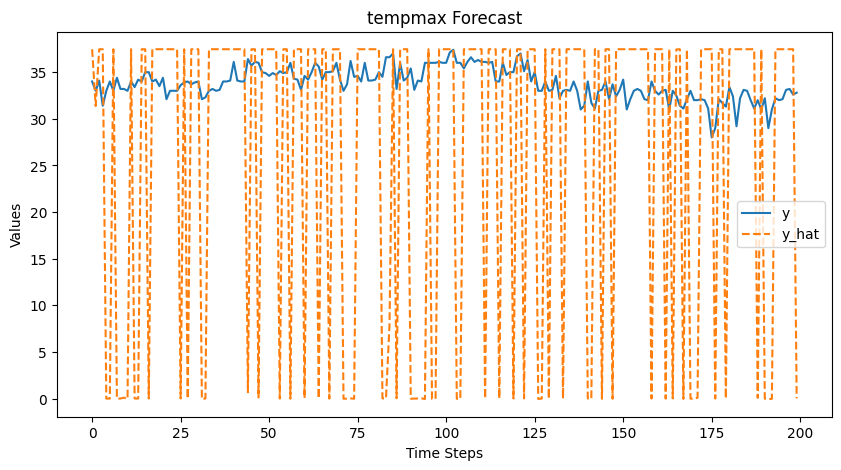

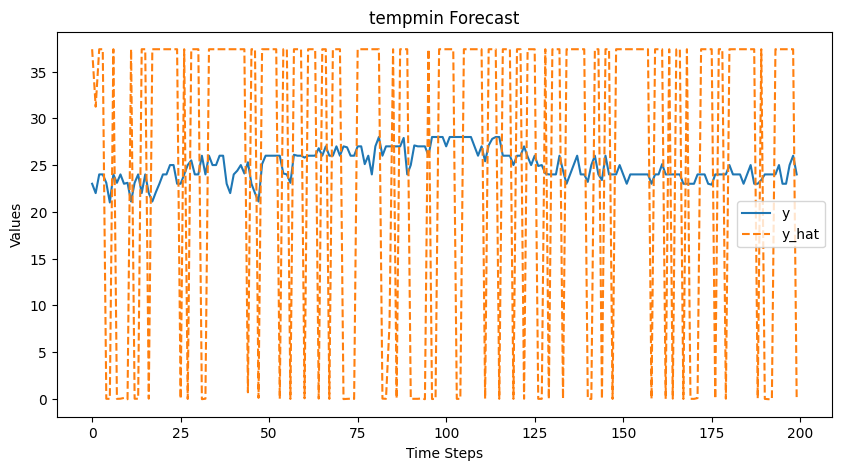

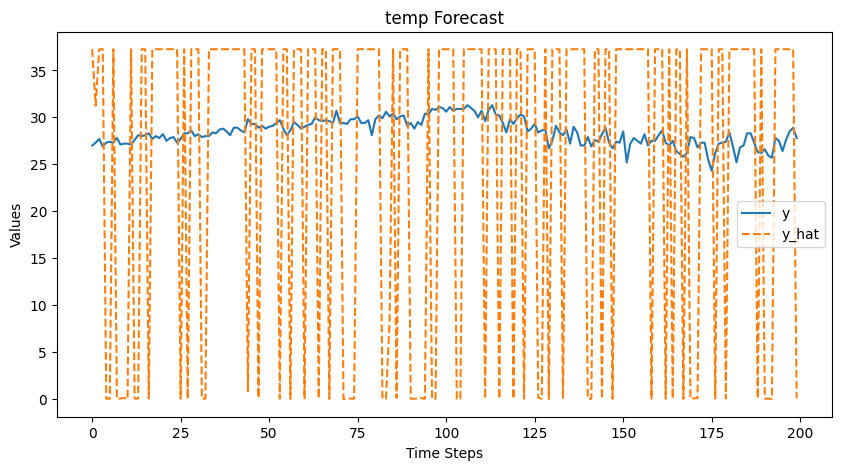

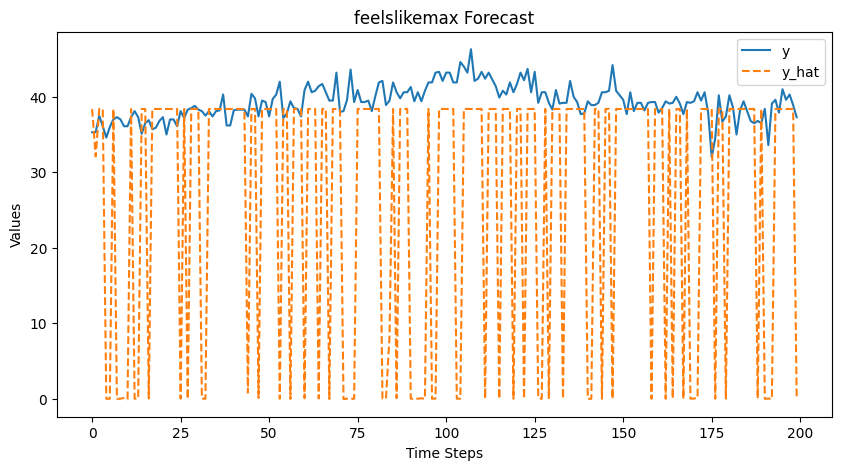

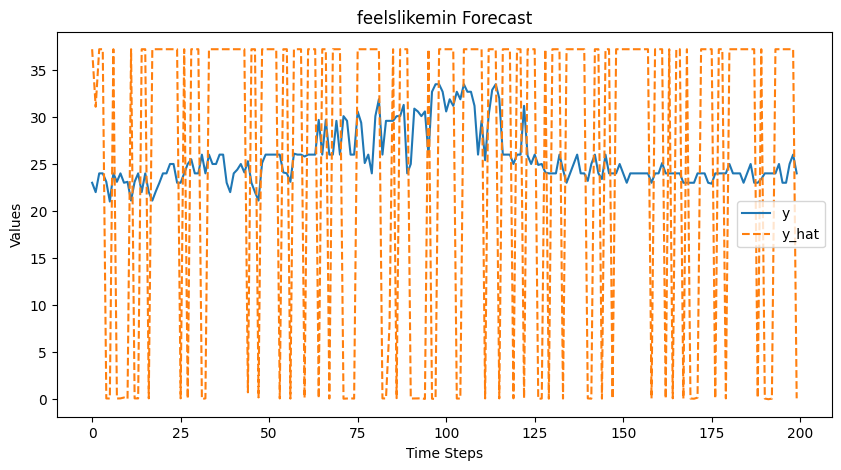

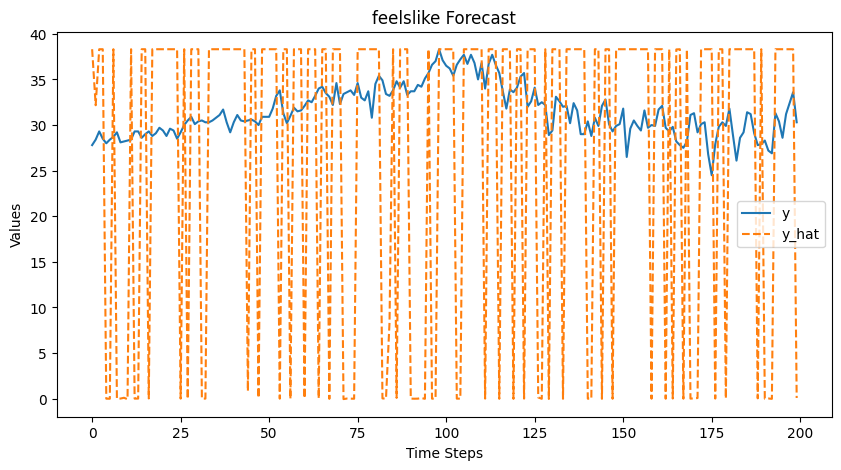

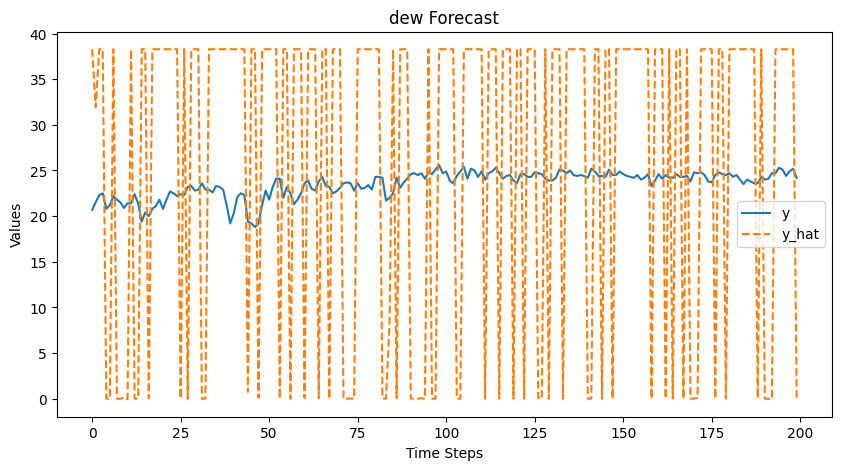

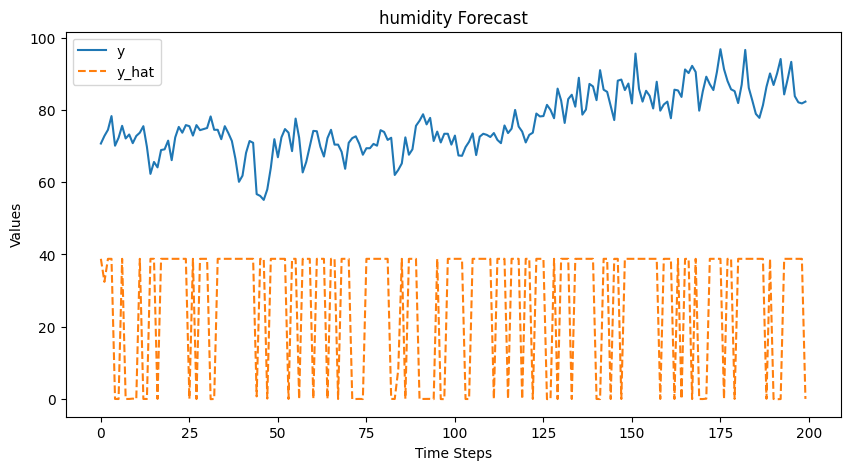

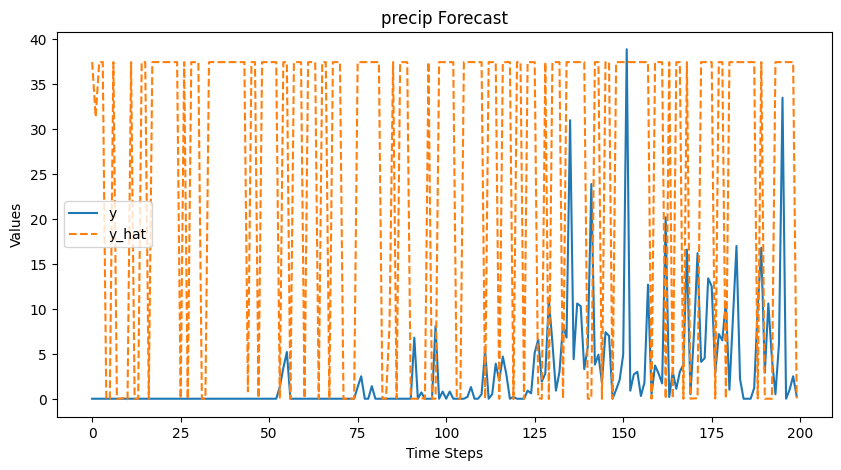

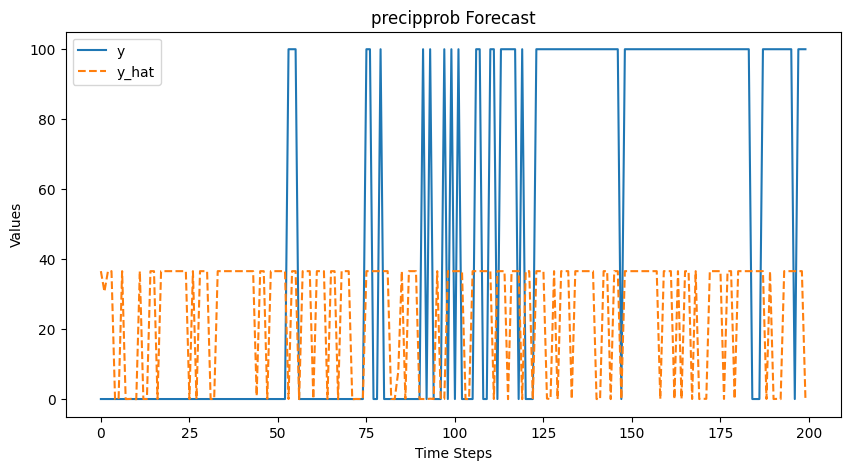

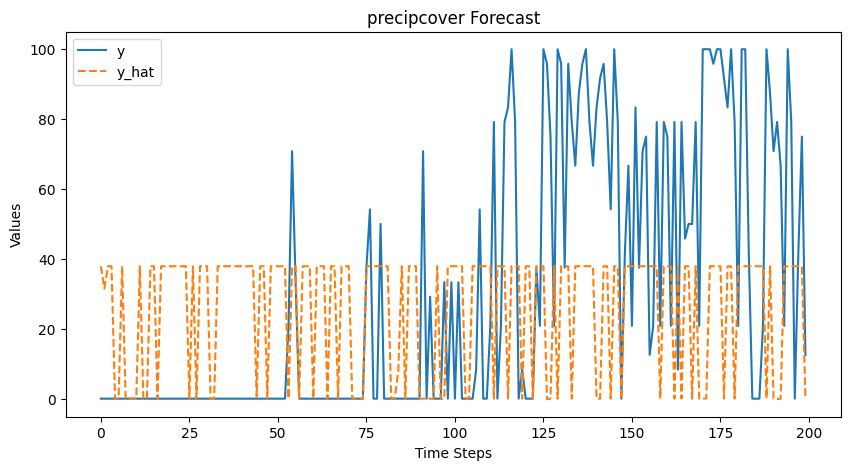

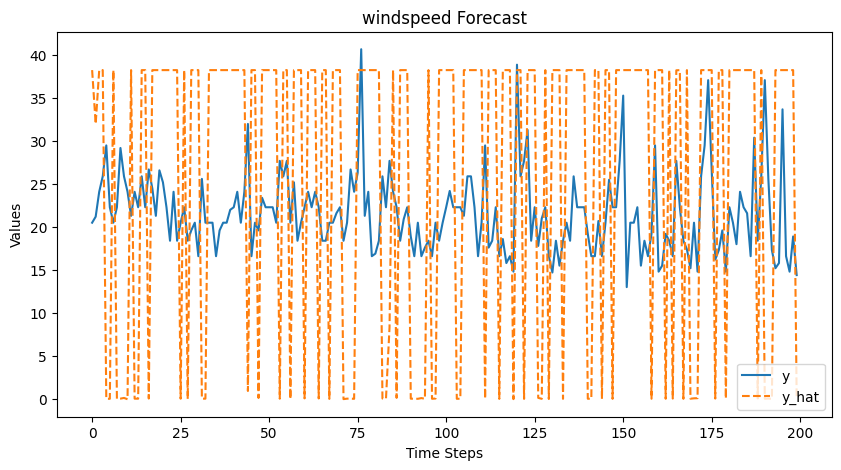

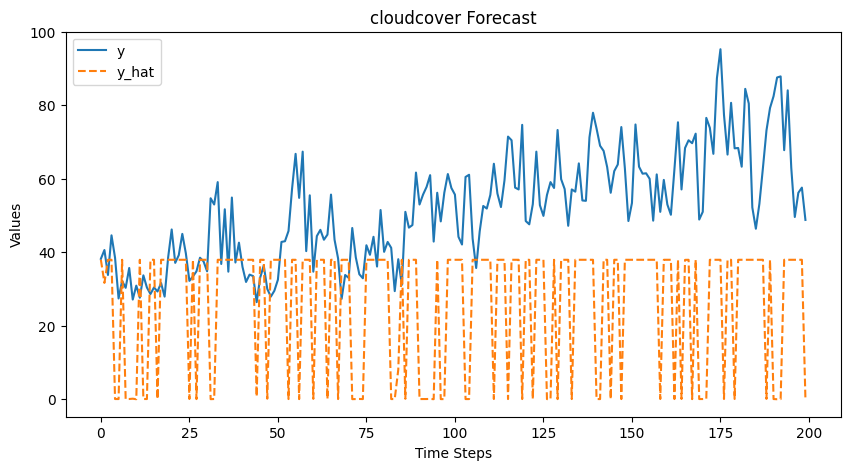

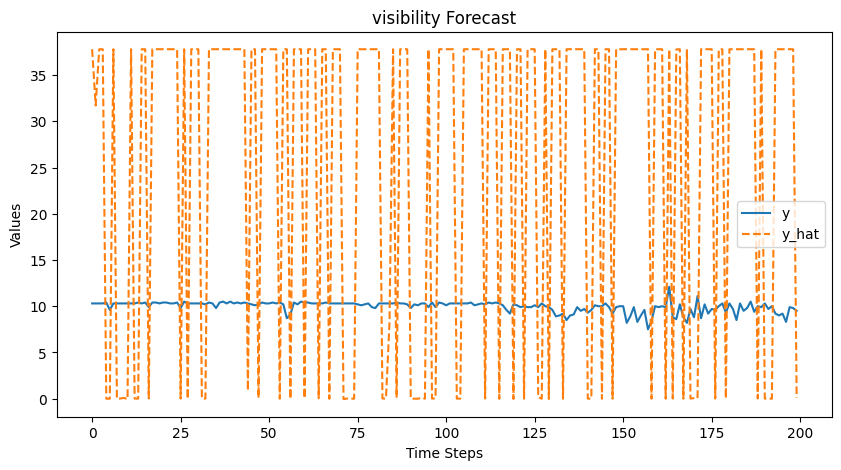

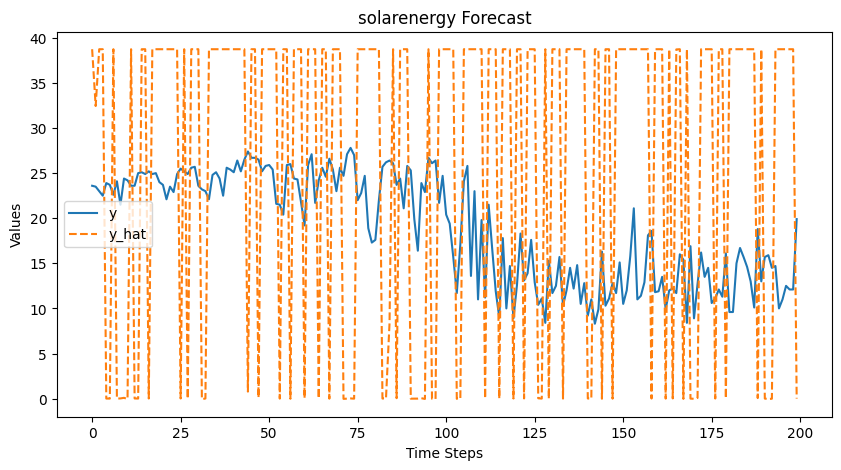

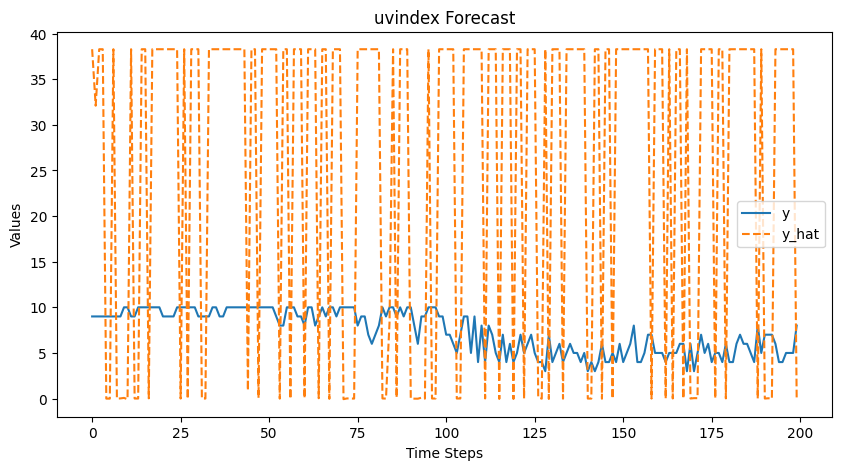

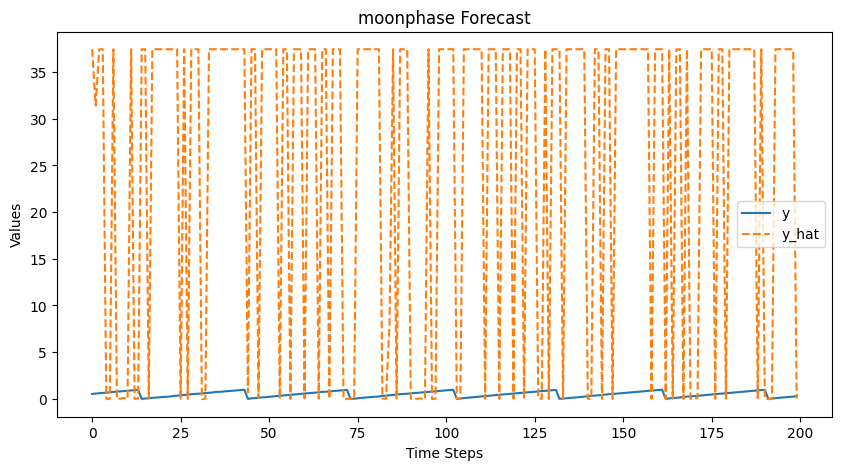

In [344]:
# Generate predictions on the training data
mul2mul_data_x = multi2multi_loader.train_loader
mul2mul_data_y = multi2multi_loader.y_train
model_activation = LSTM_multi2multi_manager
yhat = model_activation.predict(mul2mul_data_x)

# Get the true values
y = mul2mul_data_y

# Plot the true values against the predictions
model_activation.plot(y,yhat, feature_names=["tempmax","tempmin","temp","feelslikemax","feelslikemin","feelslike","dew","humidity","precip","precipprob","precipcover","windspeed","cloudcover","visibility","solarenergy","uvindex","moonphase"], num_elements=200, save_plots=False)

#### RNN Model

In [345]:
RNN_multi2multi = RNN(input_size=multi2multi_loader.in_variable, hidden_size=hidden_size,output_size = multi2multi_loader.out_variable,ahead=label_size,num_layers=num_layers)
RNN_multi2multi_manager = ModelManager(model=RNN_multi2multi,train_loader=multi2multi_loader.train_loader,val_loader=multi2multi_loader.val_loader,lr=learning_rate,patience=patience)
RNN_multi2multi_manager.train(num_epochs=num_epochs,save_dir=os.path.join(weight_dir,sub_dir))
results.append({
    "Name": RNN_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader),
})
results[-1]

Model saved to weights/multi2multi/best-RNN.pth
Epoch 1/1000000, train_loss: 28.0291, val_loss: 28.0302, time: 0.19s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 2/1000000, train_loss: 28.0117, val_loss: 27.9652, time: 0.07s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 3/1000000, train_loss: 27.8860, val_loss: 27.9404, time: 0.07s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 4/1000000, train_loss: 27.9712, val_loss: 27.8873, time: 0.07s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 5/1000000, train_loss: 27.8048, val_loss: 27.8405, time: 0.07s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 6/1000000, train_loss: 27.7124, val_loss: 27.7867, time: 0.07s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 7/1000000, train_loss: 27.6944, val_loss: 27.6754, time: 0.07s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 8/1000000, train_loss: 27.6107, val_loss: 27.6149, time: 0.07s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 9/1000000,

{'Name': 'RNN', 'Type': 'multi2multi', 'MAE': 5.501327812671661}

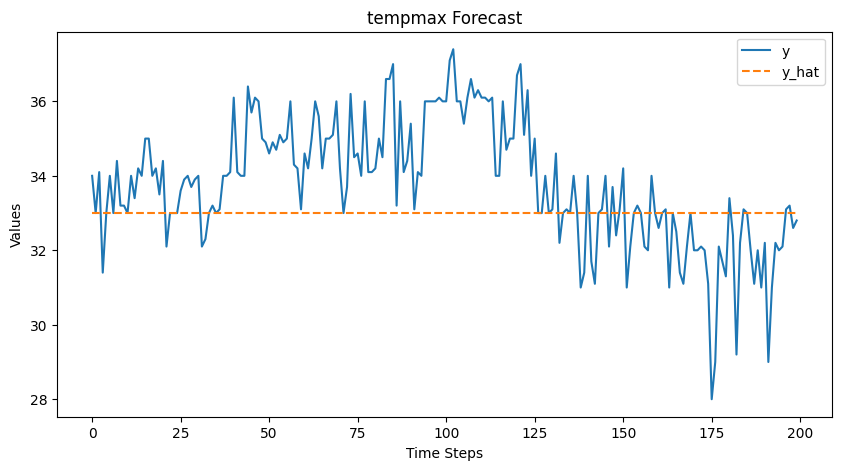

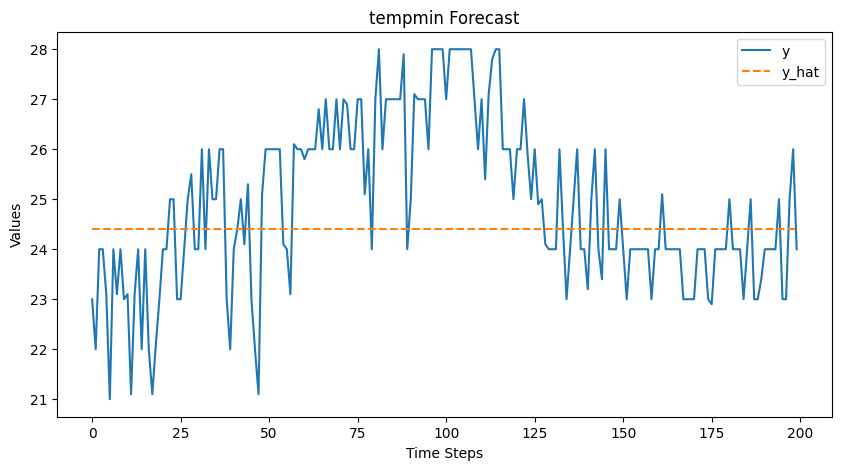

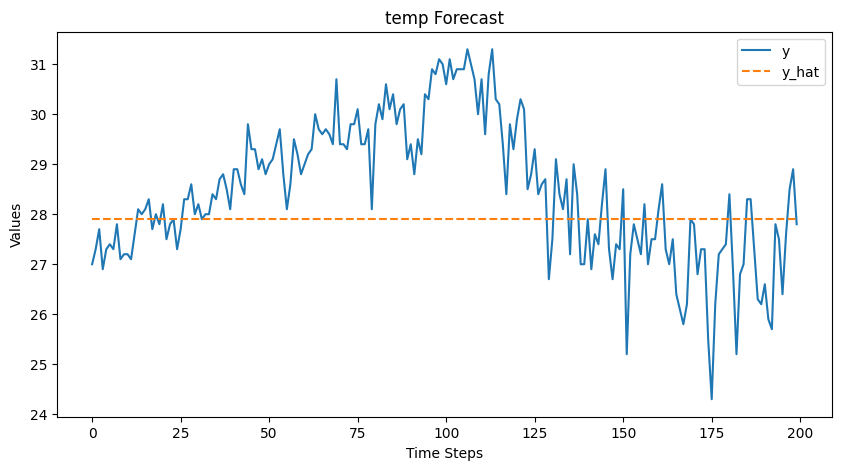

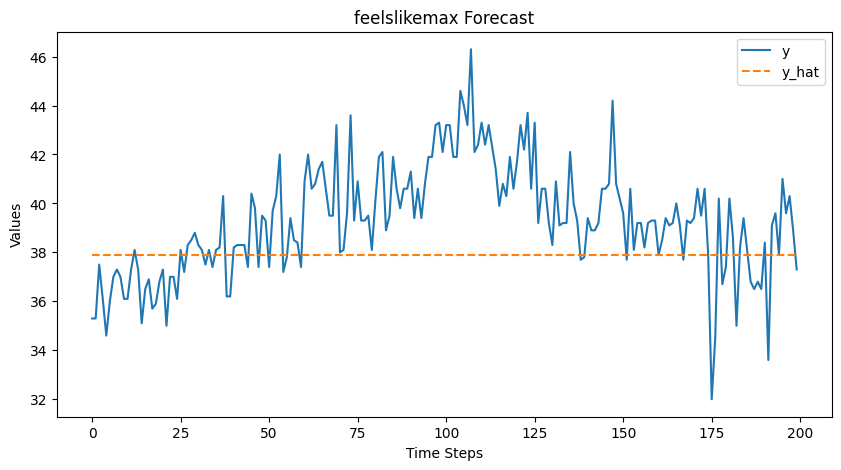

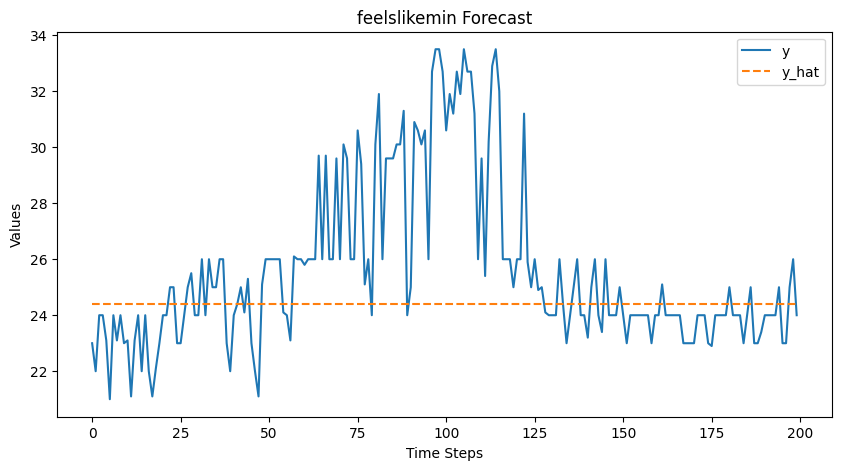

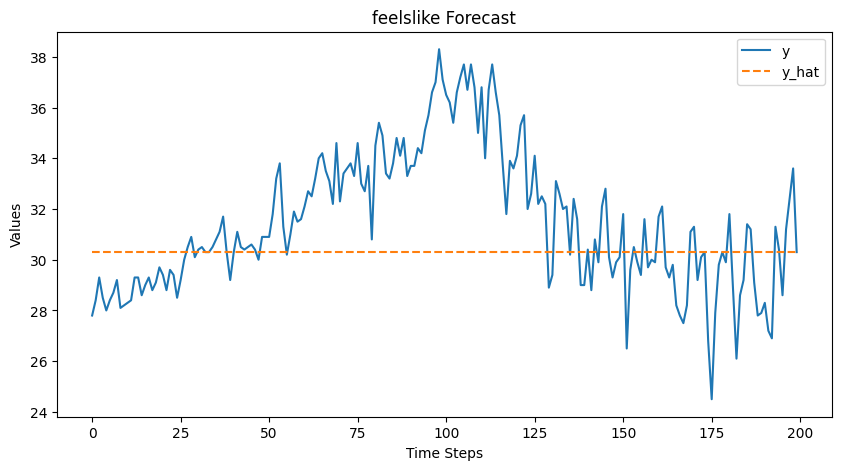

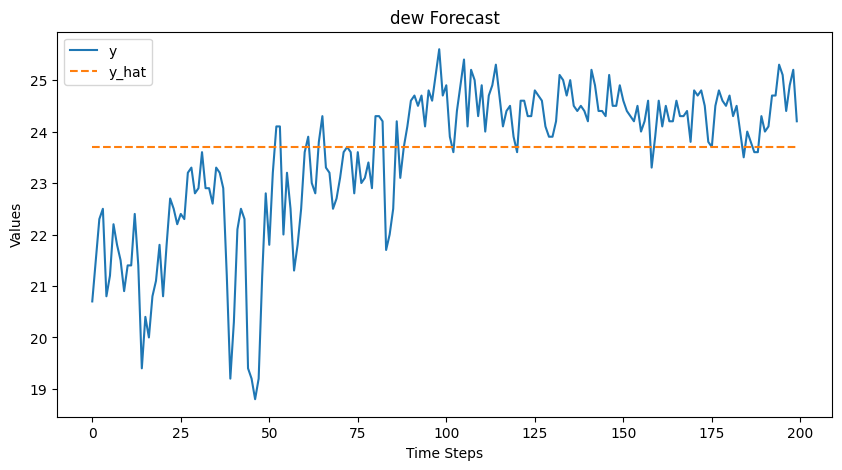

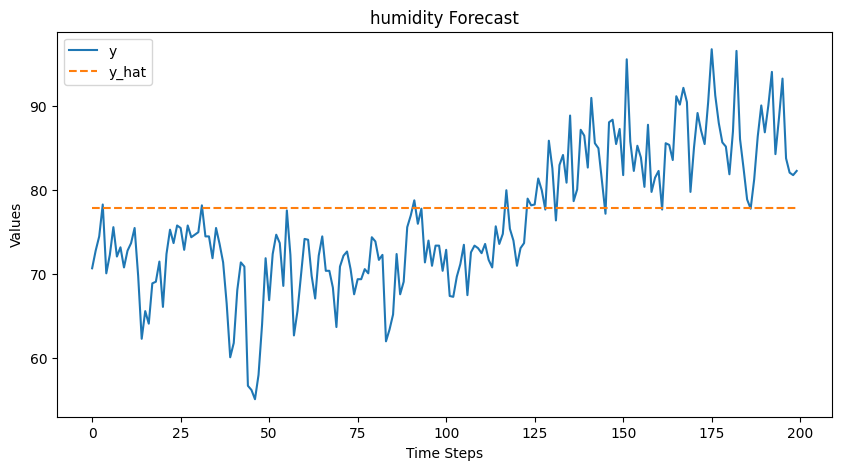

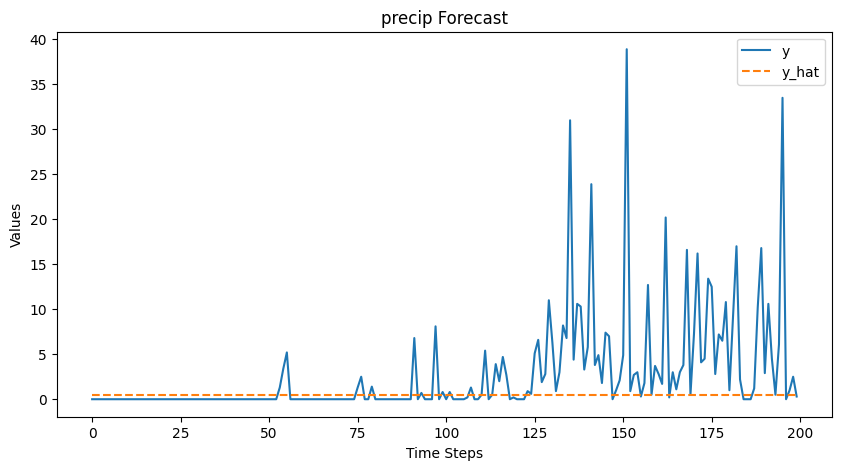

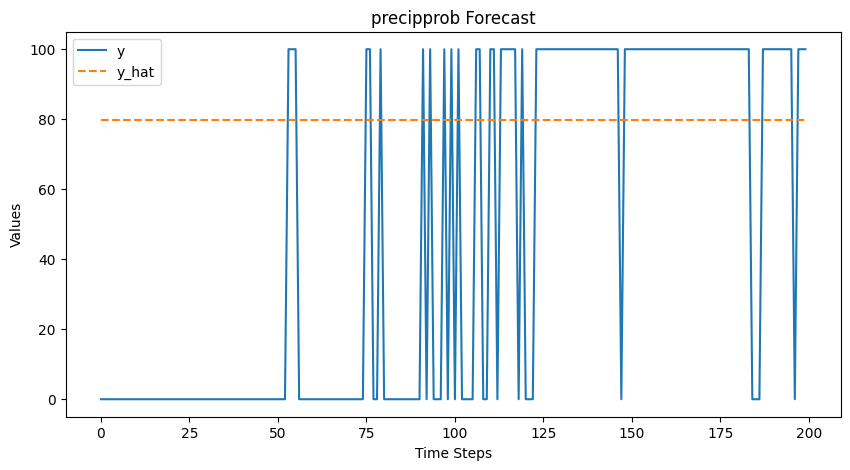

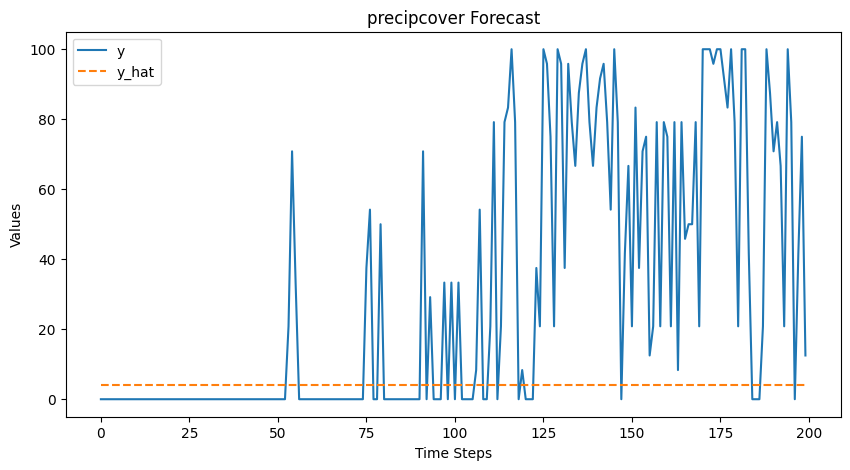

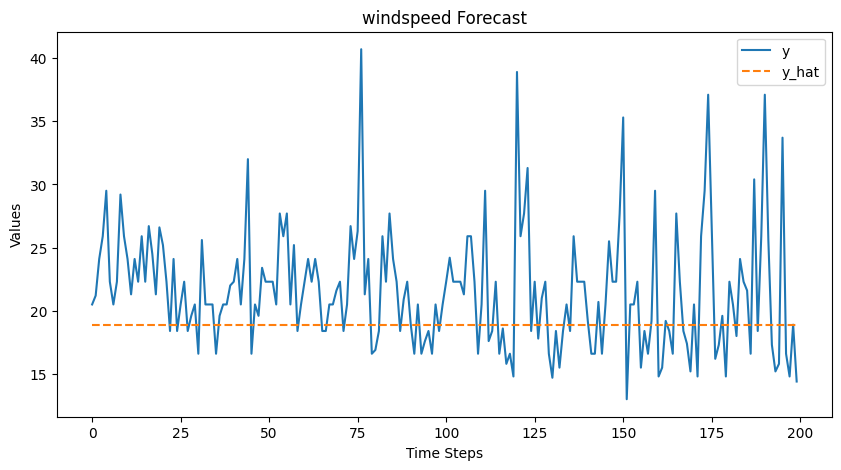

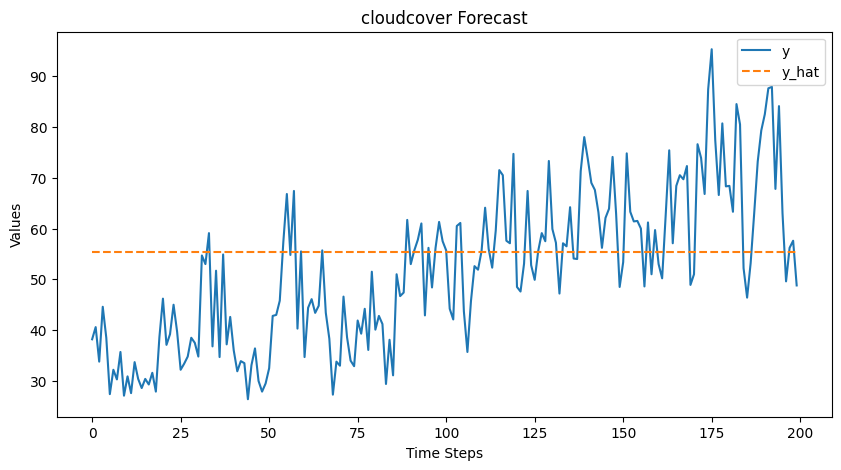

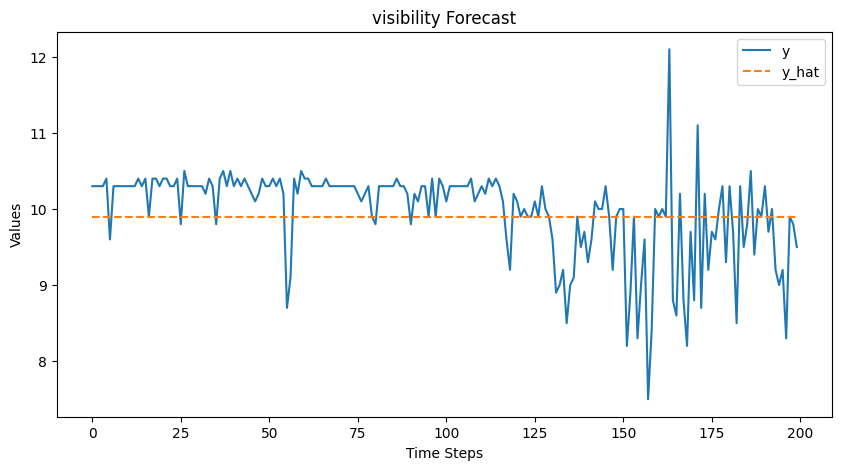

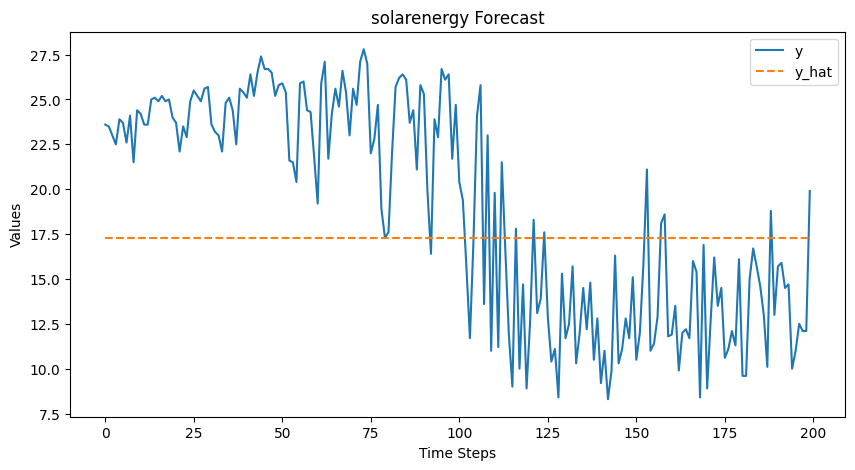

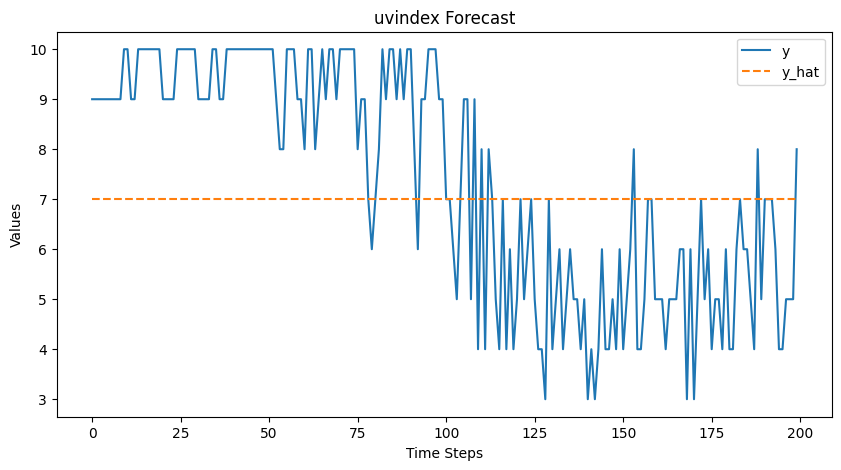

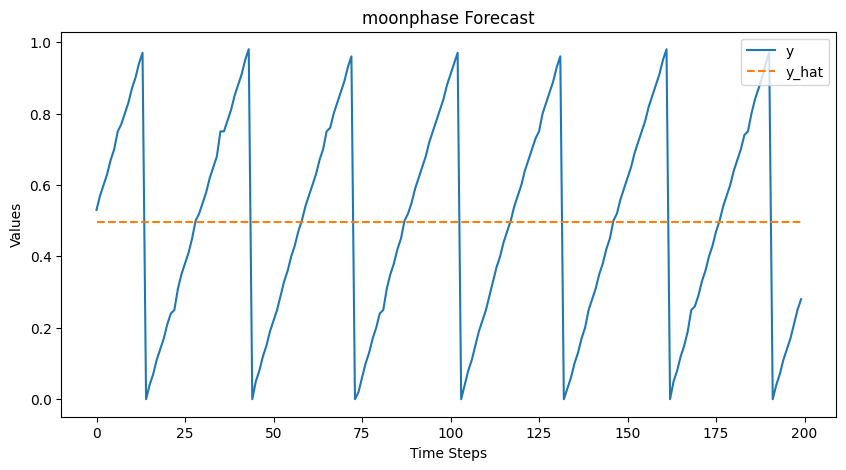

In [346]:
# Generate predictions on the training data
mul2mul_data_x = multi2multi_loader.train_loader
mul2mul_data_y = multi2multi_loader.y_train
model_activation = RNN_multi2multi_manager
yhat = model_activation.predict(mul2mul_data_x)

# Get the true values
y = mul2mul_data_y

# Plot the true values against the predictions
model_activation.plot(y,yhat, feature_names=["tempmax","tempmin","temp","feelslikemax","feelslikemin","feelslike","dew","humidity","precip","precipprob","precipcover","windspeed","cloudcover","visibility","solarenergy","uvindex","moonphase"], num_elements=200, save_plots=False)

#### BiLSTM Model

In [347]:
BiLSTM_multi2multi = BiLSTM(input_size=multi2multi_loader.in_variable, hidden_size=hidden_size, output_size=multi2multi_loader.out_variable, ahead=label_size, num_layers=num_layers)
BiLSTM_multi2multi_manager = ModelManager(model=BiLSTM_multi2multi, train_loader=multi2multi_loader.train_loader, val_loader=multi2multi_loader.val_loader, lr=0.001, patience=patience)
BiLSTM_multi2multi_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader),
})
results[-1]

Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 1/1000000, train_loss: 25.3157, val_loss: 21.8236, time: 0.17s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 2/1000000, train_loss: 19.3087, val_loss: 16.9351, time: 0.17s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 3/1000000, train_loss: 15.0204, val_loss: 13.0970, time: 0.16s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 4/1000000, train_loss: 11.9118, val_loss: 10.5853, time: 0.15s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 5/1000000, train_loss: 10.1958, val_loss: 9.2681, time: 0.15s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 6/1000000, train_loss: 9.2079, val_loss: 8.4414, time: 0.15s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 7/1000000, train_loss: 8.5243, val_loss: 7.7495, time: 0.15s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 8/1000000, train_loss: 7.9166, val_loss: 7.1490, time: 0.15s
Model saved to weights/multi2multi/best-BiLSTM.

{'Name': 'BiLSTM', 'Type': 'multi2multi', 'MAE': 5.059565514326096}

##### Visualization BiLSTM

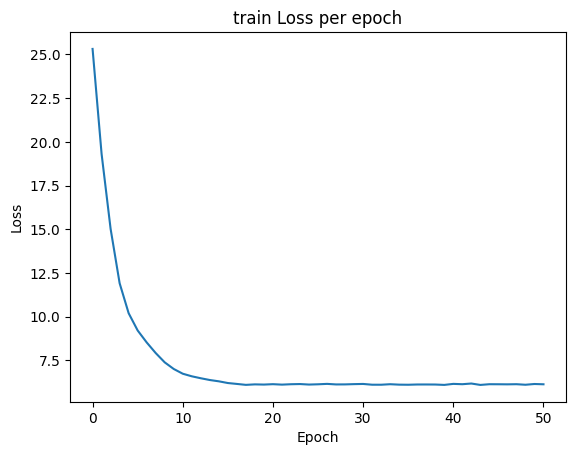

In [348]:
plt.plot(BiLSTM_multi2multi_manager.train_loss_per_epoch)
plt.title('train Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

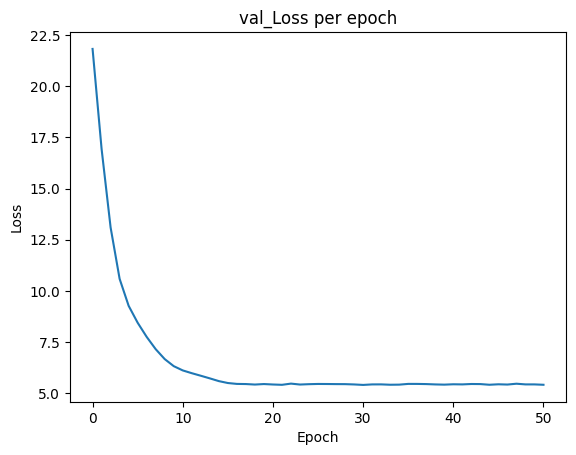

In [349]:
plt.plot(BiLSTM_multi2multi_manager.val_loss_per_epoch)
plt.title('val_Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

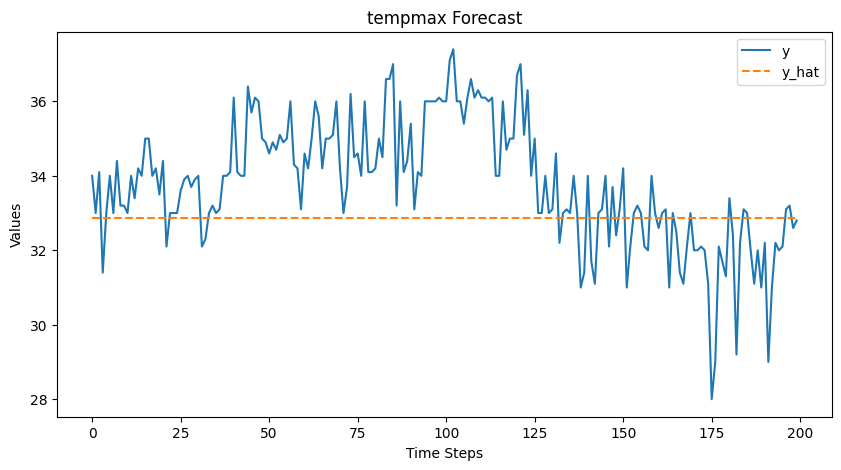

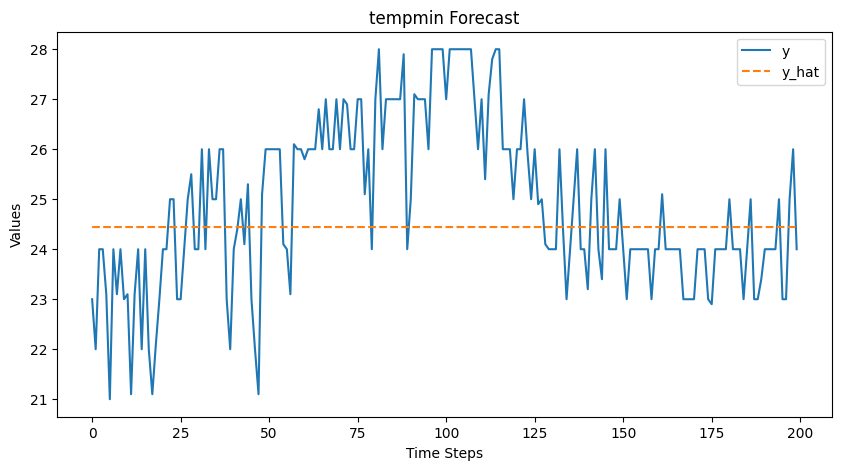

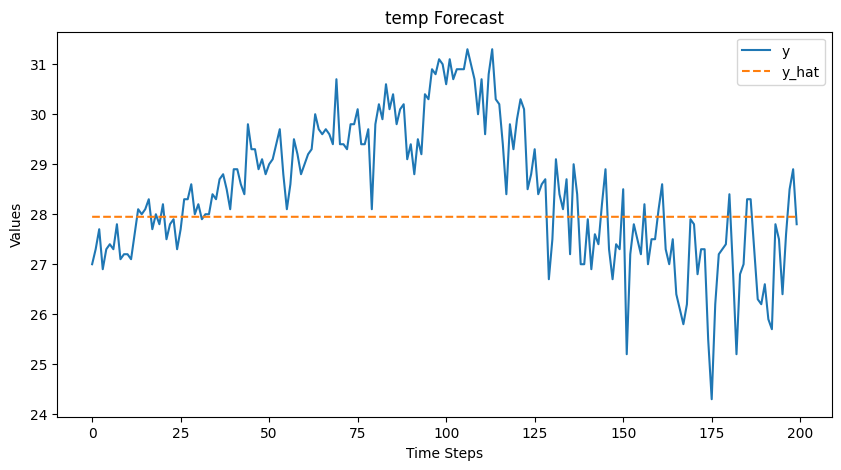

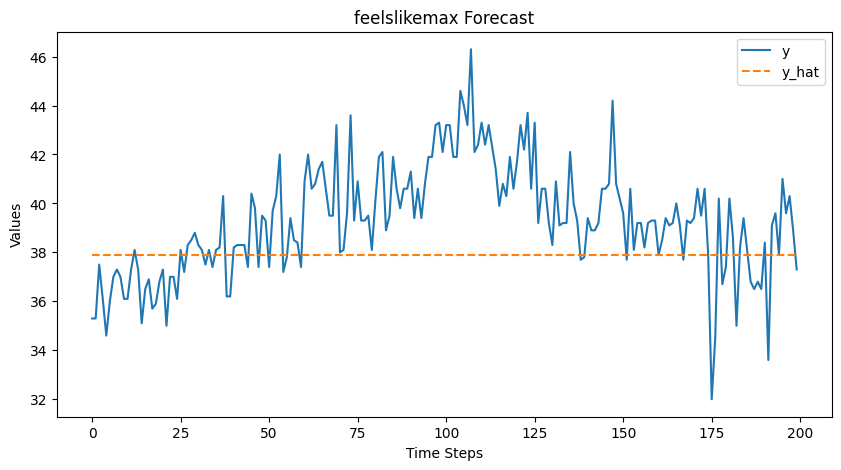

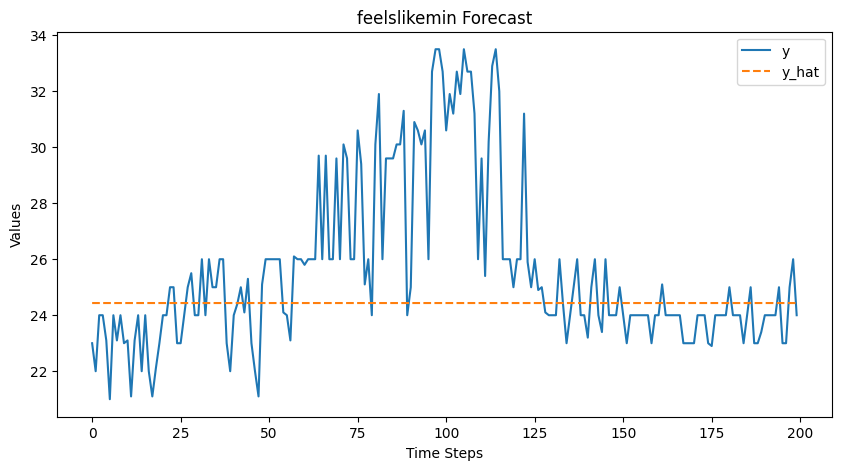

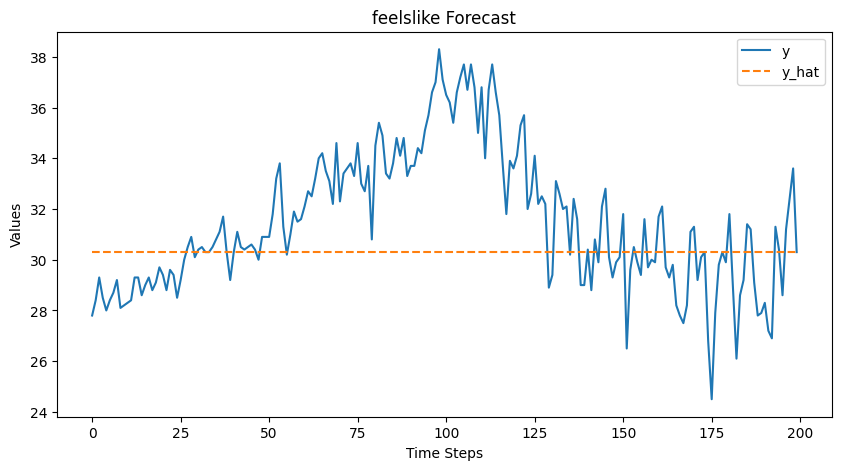

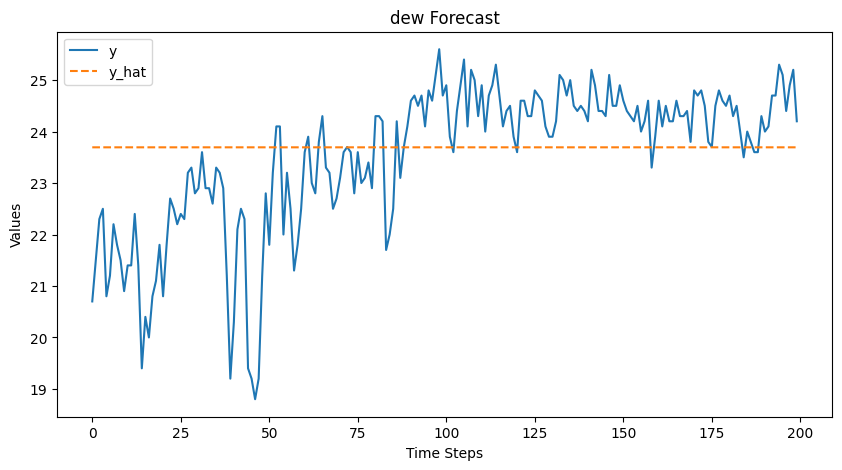

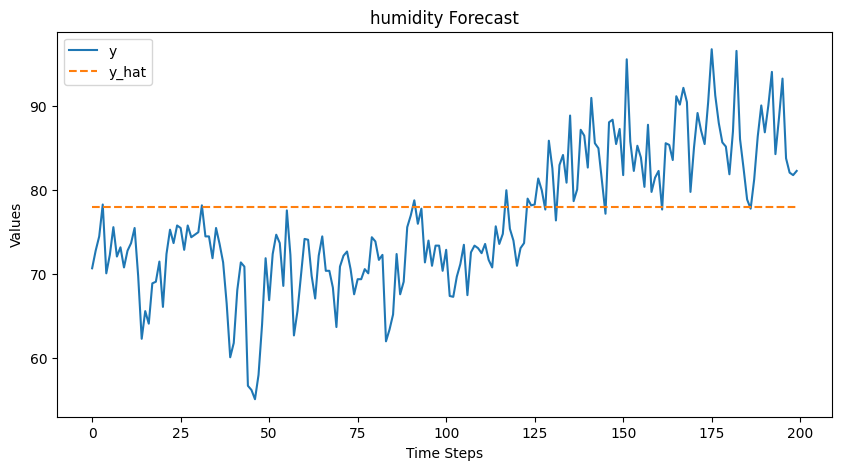

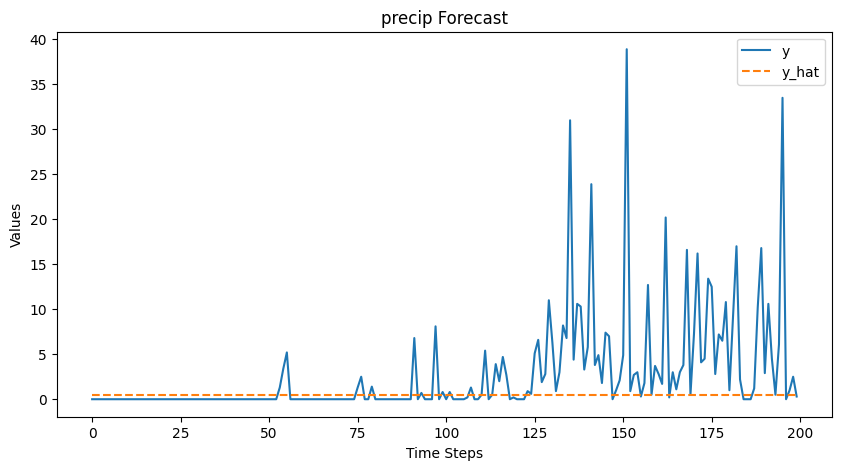

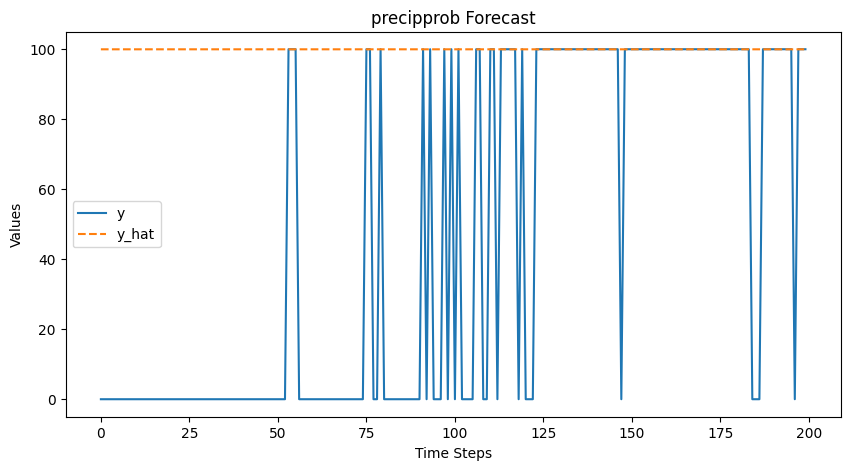

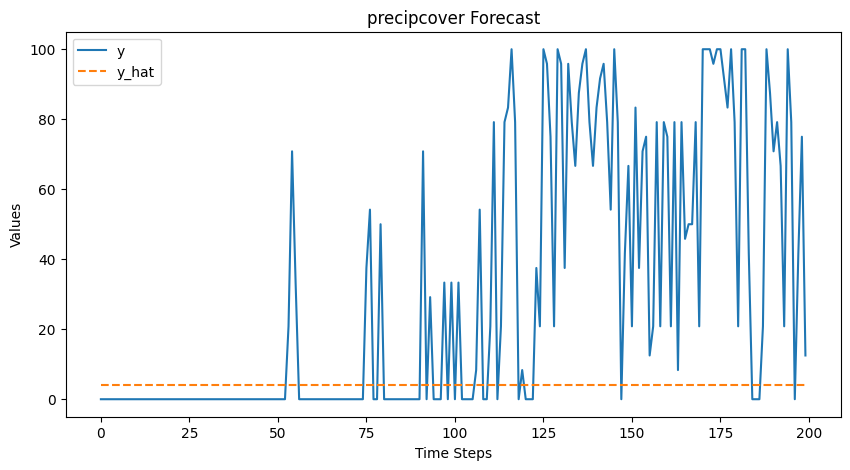

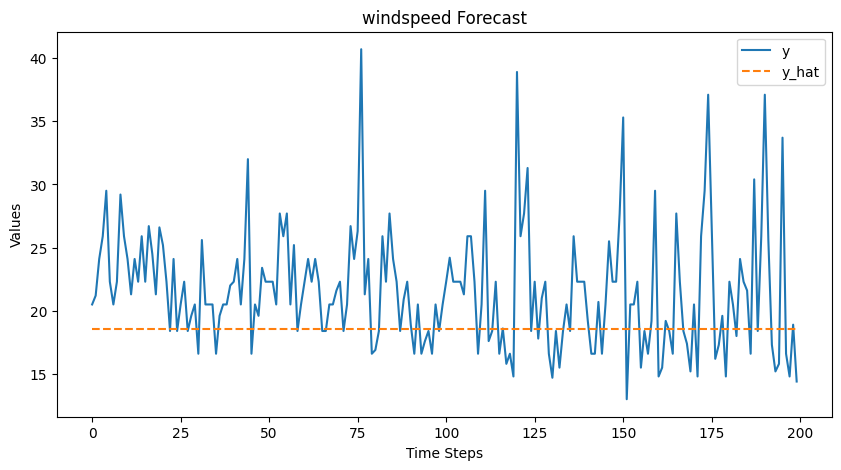

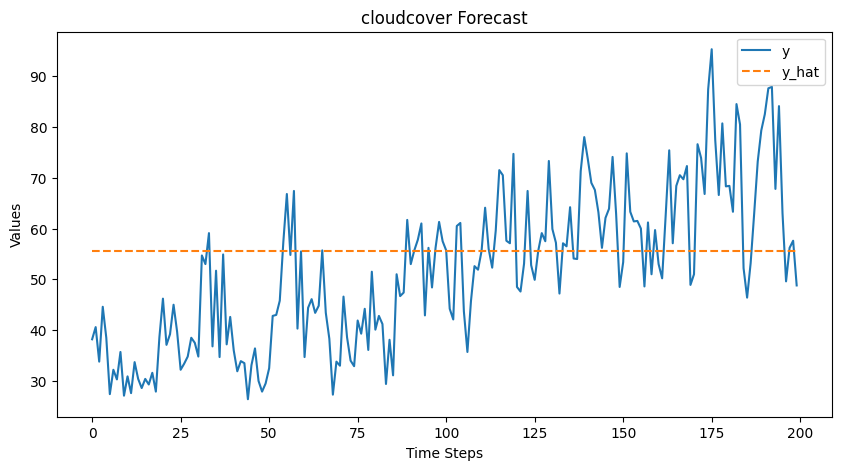

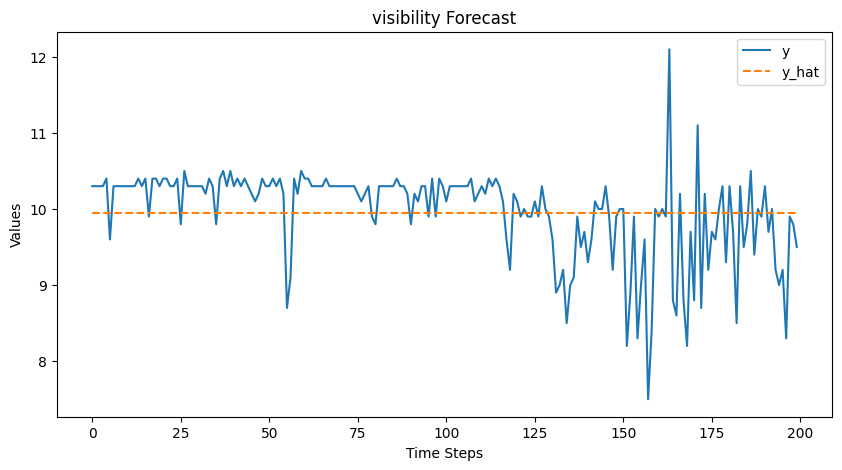

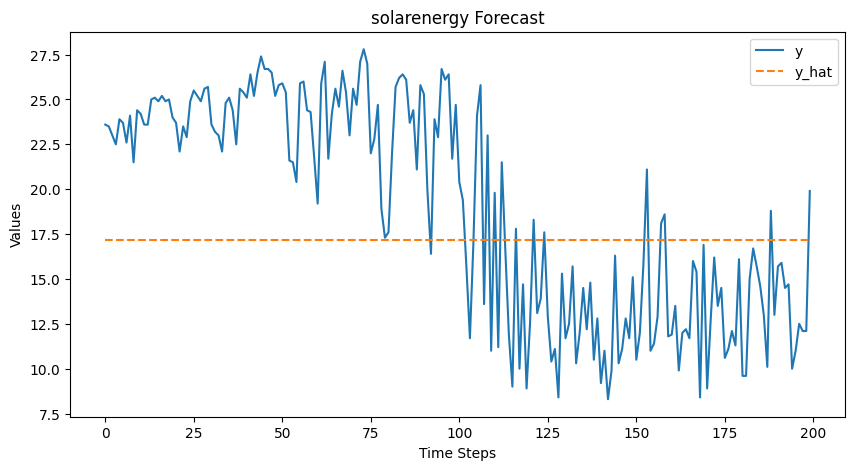

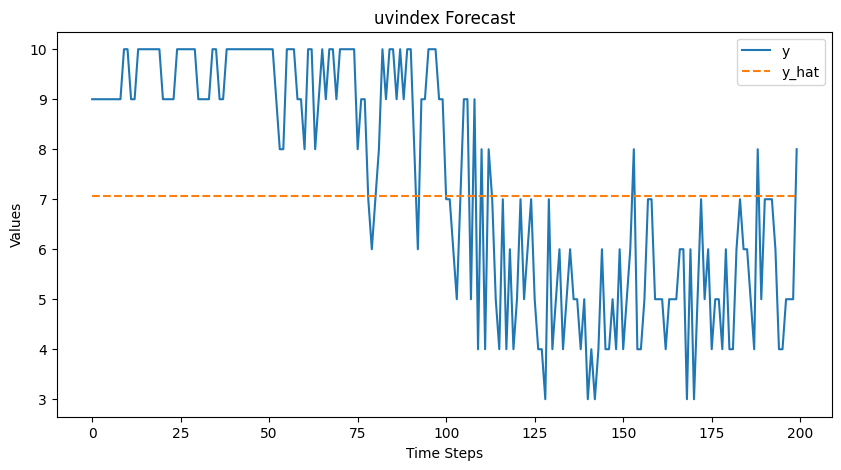

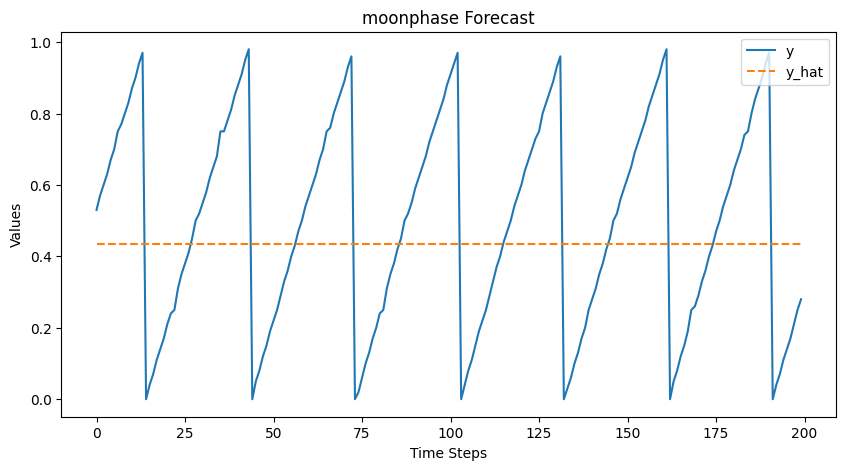

In [350]:
# Generate predictions on the training data
mul2mul_data_x = multi2multi_loader.train_loader
mul2mul_data_y = multi2multi_loader.y_train
model_activation = BiLSTM_multi2multi_manager
yhat = model_activation.predict(mul2mul_data_x)

# Get the true values
y = mul2mul_data_y

# Plot the true values against the predictions
model_activation.plot(y,yhat, feature_names=["tempmax","tempmin","temp","feelslikemax","feelslikemin","feelslike","dew","humidity","precip","precipprob","precipcover","windspeed","cloudcover","visibility","solarenergy","uvindex","moonphase"], num_elements=200, save_plots=False)

#### Prepare MAE of Models

In [351]:
results

[{'Name': 'MLP', 'Type': 'multi2multi', 'MAE': 3.550046071410179},
 {'Name': 'XGBRegressor', 'Type': 'multi2multi', 'MAE': 5.339065954803869},
 {'Name': 'LSTM', 'Type': 'multi2multi', 'MAE': 22.471189975738525},
 {'Name': 'RNN', 'Type': 'multi2multi', 'MAE': 5.501327812671661},
 {'Name': 'BiLSTM', 'Type': 'multi2multi', 'MAE': 5.059565514326096}]

In [352]:
results

[{'Name': 'MLP', 'Type': 'multi2multi', 'MAE': 3.550046071410179},
 {'Name': 'XGBRegressor', 'Type': 'multi2multi', 'MAE': 5.339065954803869},
 {'Name': 'LSTM', 'Type': 'multi2multi', 'MAE': 22.471189975738525},
 {'Name': 'RNN', 'Type': 'multi2multi', 'MAE': 5.501327812671661},
 {'Name': 'BiLSTM', 'Type': 'multi2multi', 'MAE': 5.059565514326096}]

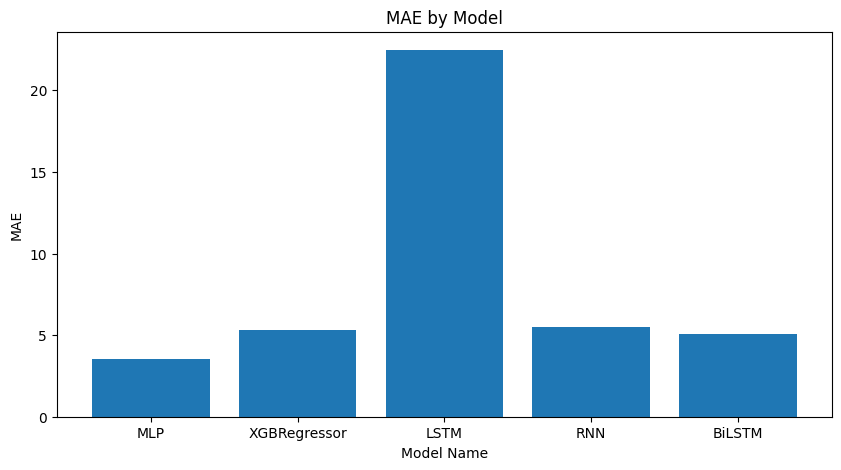

In [353]:
import matplotlib.pyplot as plt

# Extract names and MAE values
names = [result['Name'] for result in results]
mae_values = [result['MAE'] for result in results]

# Create bar chart
plt.figure(figsize=(10,5))
plt.bar(names, mae_values)
plt.xlabel('Model Name')
plt.ylabel('MAE')
plt.title('MAE by Model')

# Save the figure before displaying it
plt.savefig('result_MAE.png')

# Now display the figure
plt.show()